# West 2 Group - NLP Project
- Raymond Alvarez
- Sean Bullock
- Travis Darby
- David Smiley


### Table of Contents

[Getting the Data](#Getting_the_Data)

[Library Imports](#Library_Imports)

[EDA](#EDA)

- [Clean Text](#Clean_Text)

- [Split info Seperate Article Label DFs](#Seperate_Articles)

- [Creating datasets of words](#Datasets_of_words)

- [Circle Plots](#Circle_Plots)

- [Word Clouds](#Word_Clouds)

- [Sentiment Analysis](#Sentiment_Analysis)

- [N_grams](#N_grams)

[Baseline Model](#Baseline_Model)

[Deep Learning](#Deep_Learning)

## Getting the Data

<a id="Getting_the_Data"></a>

### Library Imports

<a id="Library Imports"></a>

In [14]:
#standard library imports
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import circlify
import time

from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import fetch_20newsgroups


from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk import ngrams


#simple models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#TensorFlow / Keras functions
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, SimpleRNN, LSTM, GRU, \
  Embedding, TextVectorization, Flatten, Dropout, GlobalAveragePooling1D, \
    Conv1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping





#HTML and regex for cleaning
from bs4 import BeautifulSoup
import re

from wordcloud import WordCloud

#sentiment Analysis
from nltk.sentiment import SentimentIntensityAnalyzer

In [2]:
#in the event a package is not downloaded
# import nltk
# nltk.download('stopwords')

In [3]:
#data import from provided code
import tensorflow_datasets as tfds
train_data, test_data = tfds.load(
  'ag_news_subset',
  split = ['train', 'test'],
  batch_size = -1
)
df_train = pd.DataFrame(train_data)
df_test = pd.DataFrame(test_data)

In [4]:
df_train.shape

(120000, 3)

In [5]:
df_test.shape

(7600, 3)

In [6]:
df_train.head()

,description,label,title
0,b'AMD #39;s new dual-core Opteron chip is desi...,3,b'AMD Debuts Dual-Core Opteron Processor'
1,b'Reuters - Major League Baseball\\Monday anno...,1,"b""Wood's Suspension Upheld (Reuters)"""
2,b'President Bush #39;s quot;revenue-neutral q...,2,b'Bush reform may have blue states seeing red'
3,b'Britain will run out of leading scientists u...,3,"b""'Halt science decline in schools'"""
4,"b'London, England (Sports Network) - England m...",1,b'Gerrard leaves practice'


### Labels
0 - World News

1 - Sports

2 - Business

3 - Science/Technology

In [7]:
#looking at example
df_train.iloc[1,]

description    b'Reuters - Major League Baseball\\Monday anno...
label                                                          1
title                      b"Wood's Suspension Upheld (Reuters)"
Name: 1, dtype: object

In [8]:
#more specific example
df_train.iloc[4,]['description']

b'London, England (Sports Network) - England midfielder Steven Gerrard injured his groin late in Thursday #39;s training session, but is hopeful he will be ready for Saturday #39;s World Cup qualifier against Austria.'

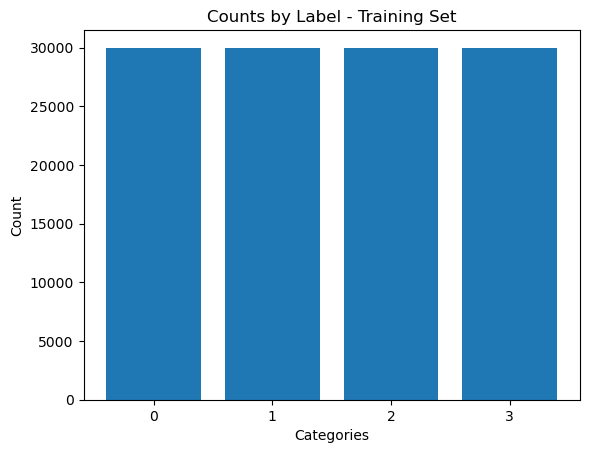

In [9]:
#plot bar chart of training set article labels
plt.bar(df_train['label'].unique(), df_train['label'].value_counts())

#labels and title
plt.xlabel('Categories')
plt.xticks(df_train['label'].unique())
plt.ylabel('Count')
plt.title('Counts by Label - Training Set')

plt.show()

- From the plot we can see that all the categories are evenly split at 30,000 each in the training set

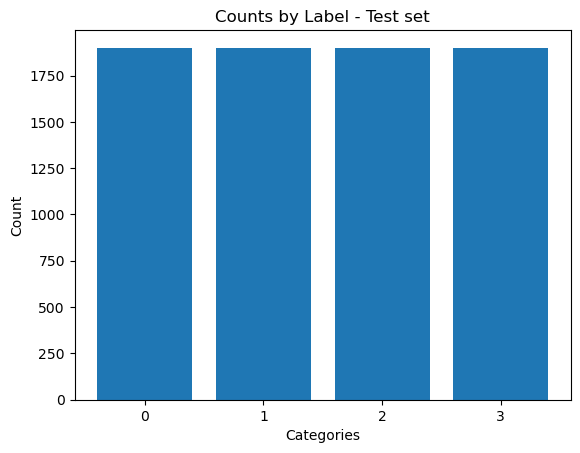

In [10]:
#plot bar chart of  test set article labels
plt.bar(df_test['label'].unique(), df_test['label'].value_counts())

#labels and title
plt.xlabel('Categories')
plt.xticks(df_test['label'].unique())
plt.ylabel('Count')
plt.title('Counts by Label - Test set')

plt.show()

- Each article count in the test set has 1900

## EDA

<a id="EDA"></a>

Before conducting EDA we knew that the success or failure of the model(s) would come down to the differences in the words, and their frequenices, within each type of article.

### Clean Text

<a id="Clean_Text"></a>

- To clean the text, we need to first get the text out of html format. We need to also remove all puncuation. There won't be anything learned from this, and if anything, puncuation will throw off the model as the words could be combined or treated as different words if they are hypenated, inside of quotes, or capitilzied. We will also shift all words to lowercase.

- After those steps, we also need to remove traces of "39s". This is an html error that came from "#39;s" which was a in the place of all apostrophes.

- We also will remove stop words from the descriptions in order to provide more meaningful words.

In [11]:
#function to convert a raw text from loaded dataset to string

#removes all non-letters
# '[^a-zA-Z]', ' '

#removes all punctuation
#r'[^\w\s\d]'

#removes all punctuation, but leaves punctuation between numbers
#r'(?<=\d)[^\w\s\d]|[^\w\s\d](?=\d)'

def clean_words(raw_description):

    #remove HTML
    description_text = BeautifulSoup(raw_description).get_text()

    #EVALUATE*************
    #remove non-letters
    # letters_only = re.sub(r'[^a-zA-Z]', '', review_text)

    #remove puncuation
    no_punct = re.sub(r'[^\w\s\d]', '', description_text)

    #removing html artifact 39s from when apostrophe errored
    final_clean = re.sub(r'39s', '', no_punct)

    #convert to lower case, split into individual words.
    words = final_clean.lower().split()

    #setting stop words
    stops = set(stopwords.words('english'))

    #remove stop words.
    meaningful_words = [w for w in words if w not in stops]

    #join the words into one string, return result.
    return(" ".join(meaningful_words))

In [15]:
#timing how long it takes to clean desriptions
start_time = time.time()

#applying function over description column creating new column
df_train['cleaned_description'] = df_train['description'].apply(clean_words)

end_time = time.time()

/var/folders/9l/8vvnk63j2j9f_hg8yf6z57v80000gn/T/ipykernel_3947/3636424674.py:15: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  description_text = BeautifulSoup(raw_description).get_text()


In [16]:
df_train

,description,label,title,cleaned_description
0,b'AMD #39;s new dual-core Opteron chip is desi...,3,b'AMD Debuts Dual-Core Opteron Processor',amd new dualcore opteron chip designed mainly ...
1,b'Reuters - Major League Baseball\\Monday anno...,1,"b""Wood's Suspension Upheld (Reuters)""",reuters major league baseballmonday announced ...
2,b'President Bush #39;s quot;revenue-neutral q...,2,b'Bush reform may have blue states seeing red',president bush quotrevenueneutral quot tax ref...
3,b'Britain will run out of leading scientists u...,3,"b""'Halt science decline in schools'""",britain run leading scientists unless science ...
4,"b'London, England (Sports Network) - England m...",1,b'Gerrard leaves practice',london england sports network england midfield...
...,...,...,...,...
119995,b'Ivan Ljubicic edged No. 7 seed Joachim Johan...,1,"b'Agassi, Ljubicic advance in Madrid Masters'",ivan ljubicic edged 7 seed joachim johansson t...
119996,b'MANAMA: A \\$1.3 billion (BD491 million) com...,2,"b'\\$1.3 billion power plant will generate 3,5...",manama 13 billion bd491 million combined power...
119997,"b'And lo, the hawk begat the dove. At least th...",0,b'Last man standing',lo hawk begat dove least one imagines private ...
119998,"b'West Palm Beach, FL (Sports Network) - Tom L...",1,b'Report: Lehman named Ryder Cup captain',west palm beach fl sports network tom lehman n...


In [18]:
elapsed_time = end_time - start_time
print(f"cleaning training set descriptions time: {elapsed_time:.4f} seconds")

cleaning training set descriptions time: 10.9953 seconds


In [19]:
#time for cleaning titles
start_time = time.time()

#applying function over description column creating new column
df_train['cleaned_title'] = df_train['title'].apply(clean_words)

end_time = time.time()

/var/folders/9l/8vvnk63j2j9f_hg8yf6z57v80000gn/T/ipykernel_3947/3636424674.py:15: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  description_text = BeautifulSoup(raw_description).get_text()


In [20]:
df_train

,description,label,title,cleaned_description,cleaned_title
0,b'AMD #39;s new dual-core Opteron chip is desi...,3,b'AMD Debuts Dual-Core Opteron Processor',amd new dualcore opteron chip designed mainly ...,amd debuts dualcore opteron processor
1,b'Reuters - Major League Baseball\\Monday anno...,1,"b""Wood's Suspension Upheld (Reuters)""",reuters major league baseballmonday announced ...,woods suspension upheld reuters
2,b'President Bush #39;s quot;revenue-neutral q...,2,b'Bush reform may have blue states seeing red',president bush quotrevenueneutral quot tax ref...,bush reform may blue states seeing red
3,b'Britain will run out of leading scientists u...,3,"b""'Halt science decline in schools'""",britain run leading scientists unless science ...,halt science decline schools
4,"b'London, England (Sports Network) - England m...",1,b'Gerrard leaves practice',london england sports network england midfield...,gerrard leaves practice
...,...,...,...,...,...
119995,b'Ivan Ljubicic edged No. 7 seed Joachim Johan...,1,"b'Agassi, Ljubicic advance in Madrid Masters'",ivan ljubicic edged 7 seed joachim johansson t...,agassi ljubicic advance madrid masters
119996,b'MANAMA: A \\$1.3 billion (BD491 million) com...,2,"b'\\$1.3 billion power plant will generate 3,5...",manama 13 billion bd491 million combined power...,13 billion power plant generate 3500 jobs
119997,"b'And lo, the hawk begat the dove. At least th...",0,b'Last man standing',lo hawk begat dove least one imagines private ...,last man standing
119998,"b'West Palm Beach, FL (Sports Network) - Tom L...",1,b'Report: Lehman named Ryder Cup captain',west palm beach fl sports network tom lehman n...,report lehman named ryder cup captain


### Split info Seperate Article Label DFs

<a id="Seperate_Articles"></a>

In [22]:
#0 - World News
world_news_df_train = df_train[df_train['label']==0]

world_news_df_train.shape

(30000, 5)

In [23]:
#1 - Sports
sports_df_train = df_train[df_train['label']==1]

sports_df_train.shape

(30000, 5)

In [24]:
#2 - Business
business_df_train = df_train[df_train['label']==2]

business_df_train.shape

(30000, 5)

In [25]:
#3 - Science/Tech
science_df_train = df_train[df_train['label']==3]

science_df_train.shape

(30000, 5)

### Creating datasets of words

<a id="Datasets_of_words"></a>

In [26]:
def word_counts_df(texts):
    #tokenize the texts into words
    tokenized_texts = [word_tokenize(text) for text in texts]

    #count the occurrences of each word
    word_counts_list = [Counter(tokens) for tokens in tokenized_texts]

    #merge all the counters into one
    total_word_counts = sum(word_counts_list, Counter())

    #create a DataFrame from the merged counters
    word_counts_df = pd.DataFrame(list(total_word_counts.items()), columns=['Word', 'Count'])

    return word_counts_df

In [27]:
world_news_words = word_counts_df(world_news_df_train['cleaned_description'])

In [28]:
world_news_words.head()

,Word,Count
0,tokyo,345
1,sony,8
2,corp,84
3,banking,15
4,3,72


In [29]:
sports_words = word_counts_df(sports_df_train['cleaned_description'])

In [30]:
business_words = word_counts_df(business_df_train['cleaned_description'])

In [31]:
science_tech_words = word_counts_df(science_df_train['cleaned_description'])

#### Plotting most frequent words

In [32]:
#creating function to plot the top words from each article label df
def plot_top_words(word_counts_df, top_n=10, df_name = "ENTER DF NAME"):
    #select the top number of words
    top_words_df = word_counts_df.sort_values(by='Count', ascending=False).head(top_n)

    #use a color palette for the bars
    colors = sns.color_palette("viridis", n_colors=top_n)

    #plot horizontal bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(top_words_df['Word'], top_words_df['Count'], color=colors)
    plt.xlabel('Count')
    plt.ylabel('Words')
    plt.title(f'Top {top_n} Words - {df_name}')
    plt.show()

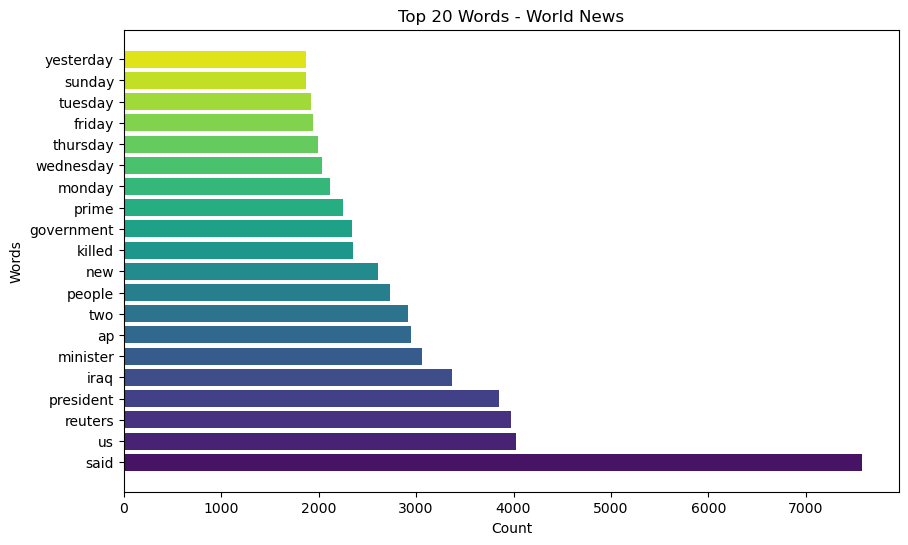

In [33]:
#plotting world news top words
plot_top_words(world_news_words, top_n=20, df_name="World News")

prime, government, killed, people, minister, iraq, president

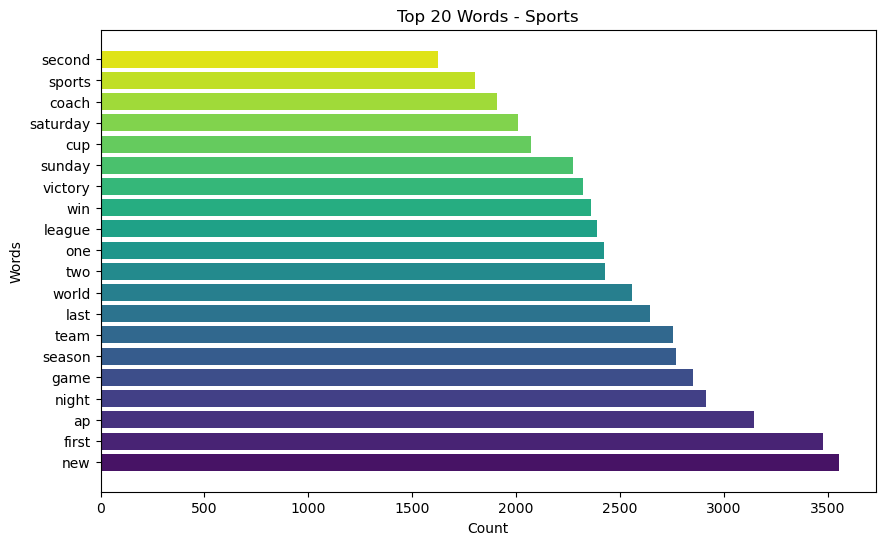

In [34]:
#plotting top sports words
plot_top_words(sports_words, top_n=20, df_name="Sports")

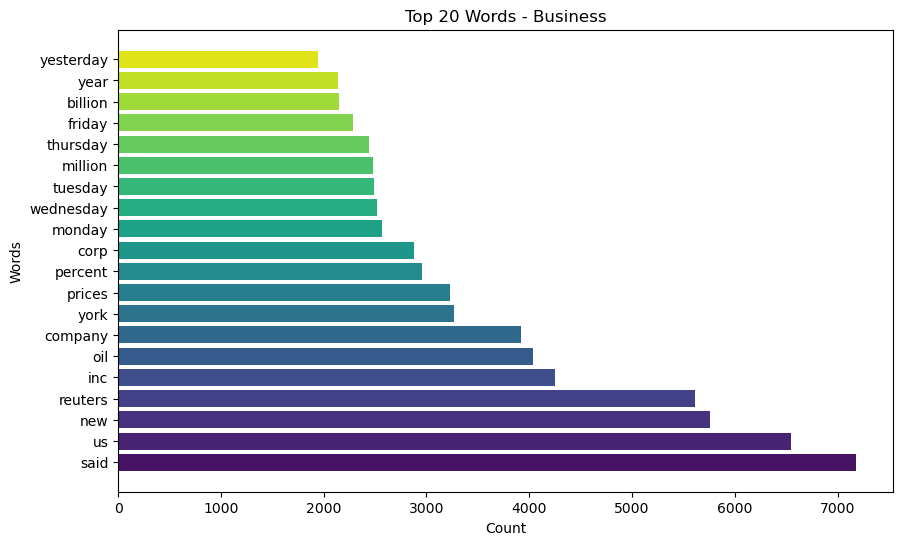

In [35]:
#plotting top business words
plot_top_words(business_words, top_n=20, df_name="Business")

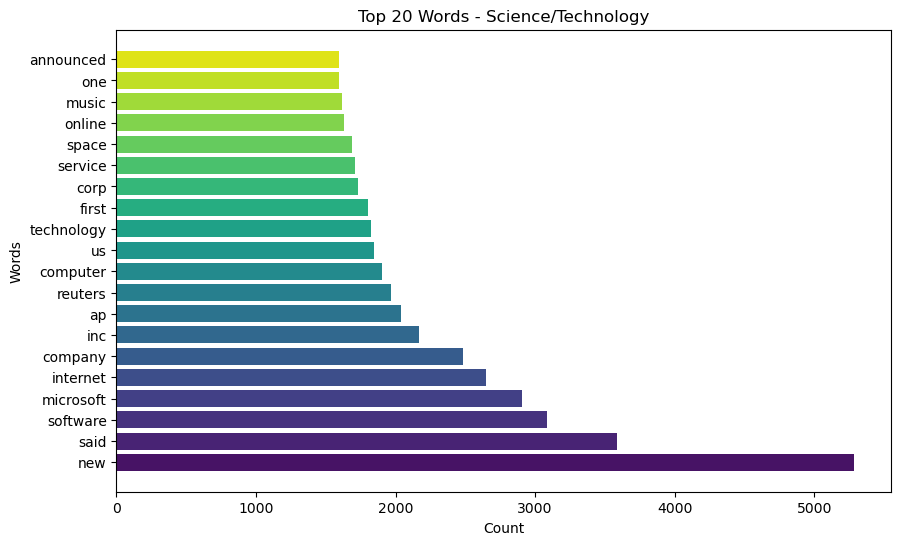

In [36]:
#plotting top science/technology words
plot_top_words(science_tech_words, top_n=20, df_name="Science/Technology")

##### **There are some differences between the types of articles and the top words.**

World News unique words
- prime, government, killed, people, minister, iraq, president

Sports unique words
- sport, coach, win, cup, team, season

Business unique words
- million, crop, prices, york

Science/Technology unique words
- announced, online, space, technology, computer

Words that are similar across all types of articles
- said, new,
- several days of the week were top words in the World News, Sports, and Business articles

It might be worth removing the words that are frequent and appear in most of the article types

### Circle Plots

<a id="Circle_Plots"></a>

In [37]:
#pip install circlify

In [38]:
#create function to get a color dictionary
def get_colordict(palette,number,start):
    pal = list(sns.color_palette(palette=palette, n_colors=number).as_hex())
    color_d = dict(enumerate(pal, start=start))
    return color_d

#### World News Circles

In [39]:
# compute circle positions:
circles = circlify.circlify(world_news_words.sort_values(by='Count', ascending=False)['Count'][0:30].tolist(),
                            show_enclosure=False,
                            target_enclosure=circlify.Circle(x=0, y=0))
# n = world_news_words['Count'][0:30].max()
n = world_news_words.sort_values(by='Count', ascending=False)['Count'][0:30].max()
color_dict = get_colordict('RdYlBu_r',n ,1)



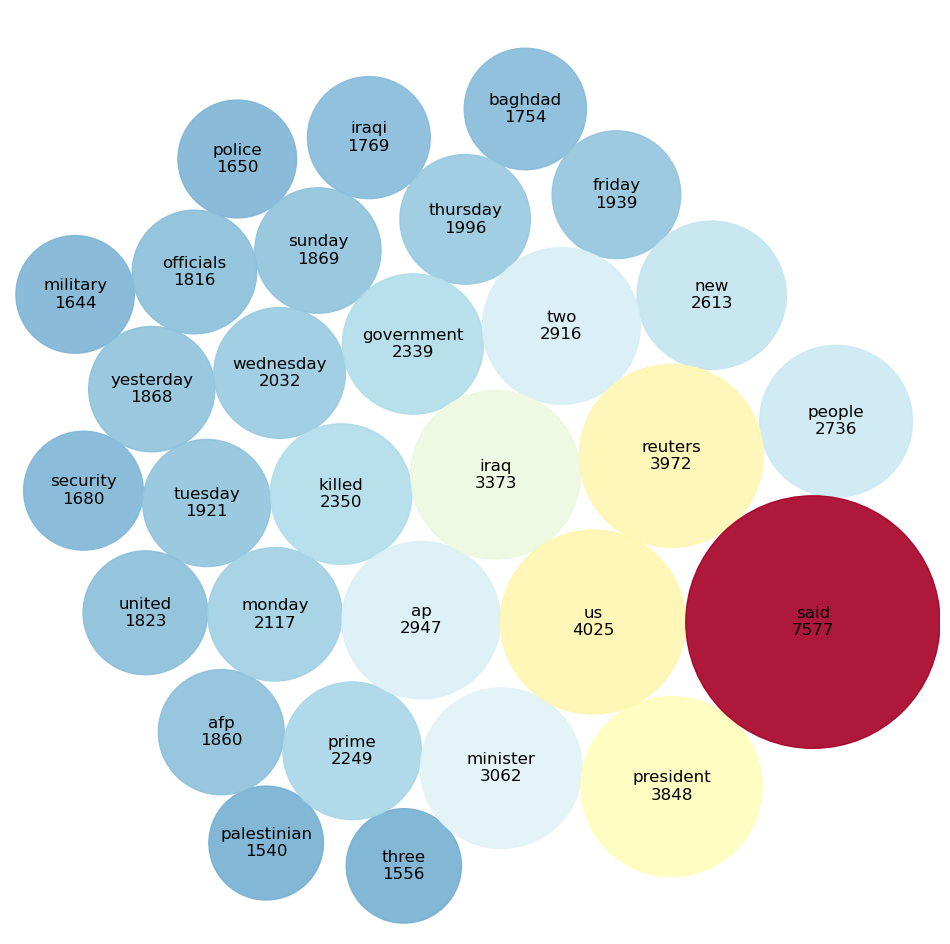

In [40]:
fig, ax = plt.subplots(figsize=(12,12), facecolor='white')
ax.axis('off')
lim = max(max(abs(circle.x)+circle.r, abs(circle.y)+circle.r,) for circle in circles)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

# list of labels
labels = list(world_news_words.sort_values(by='Count', ascending=False)['Word'][0:30])
counts = list(world_news_words.sort_values(by='Count', ascending=False)['Count'][0:30])
labels.reverse()
counts.reverse()

#print circles
for circle, label, count in zip(circles, labels, counts):
    x, y, r = circle
    ax.add_patch(plt.Circle((x, y), r, alpha=0.9, color = color_dict.get(count)))
    plt.annotate(label +'\n'+ str(count), (x,y), size=12, va='center', ha='center')
plt.xticks([])
plt.yticks([])
plt.show()

#### Sports Circles

In [42]:
# compute circle positions:
circles = circlify.circlify(sports_words.sort_values(by='Count', ascending=False)['Count'][0:30].tolist(),
                            show_enclosure=False,
                            target_enclosure=circlify.Circle(x=0, y=0))
# n = world_news_words['Count'][0:30].max()
n = sports_words.sort_values(by='Count', ascending=False)['Count'][0:30].max()
color_dict = get_colordict('RdYlBu_r',n ,1)



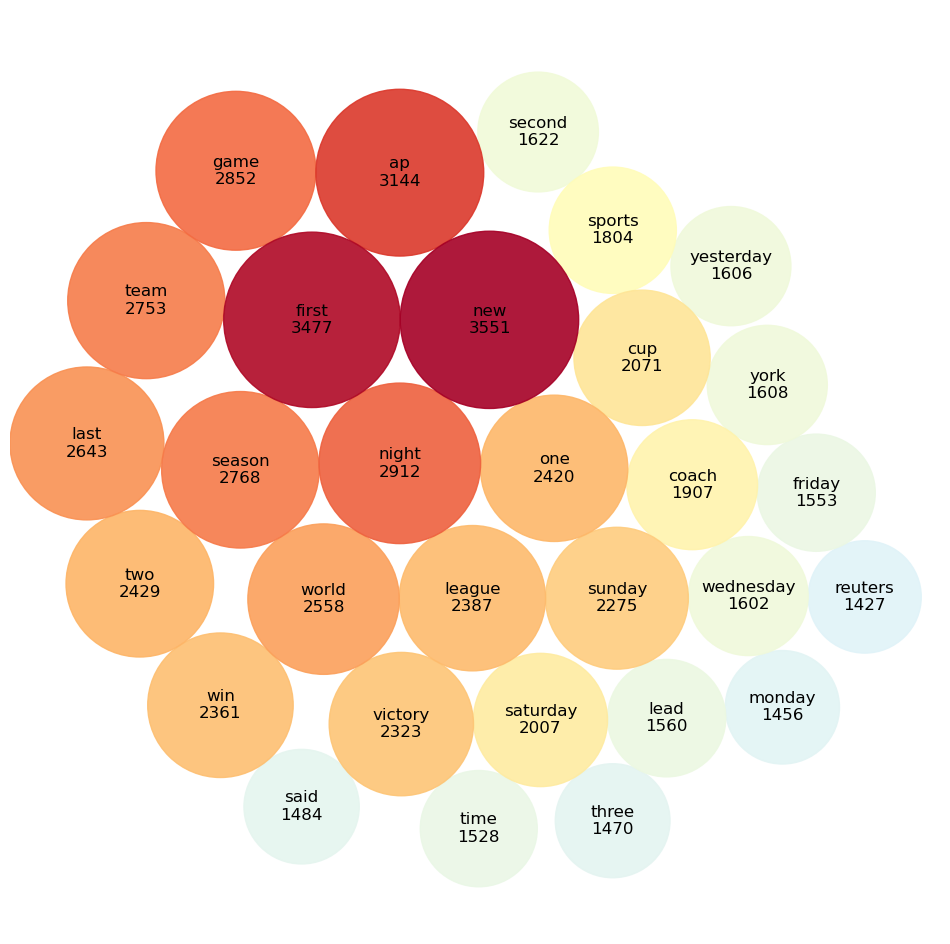

In [43]:
fig, ax = plt.subplots(figsize=(12,12), facecolor='white')
ax.axis('off')
lim = max(max(abs(circle.x)+circle.r, abs(circle.y)+circle.r,) for circle in circles)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

# list of labels
labels = list(sports_words.sort_values(by='Count', ascending=False)['Word'][0:30])
counts = list(sports_words.sort_values(by='Count', ascending=False)['Count'][0:30])
labels.reverse()
counts.reverse()

#print circles
for circle, label, count in zip(circles, labels, counts):
    x, y, r = circle
    ax.add_patch(plt.Circle((x, y), r, alpha=0.9, color = color_dict.get(count)))
    plt.annotate(label +'\n'+ str(count), (x,y), size=12, va='center', ha='center')
plt.xticks([])
plt.yticks([])
plt.show()

#### Business Circles

In [44]:
# compute circle positions:
circles = circlify.circlify(business_words.sort_values(by='Count', ascending=False)['Count'][0:30].tolist(),
                            show_enclosure=False,
                            target_enclosure=circlify.Circle(x=0, y=0))

n = business_words.sort_values(by='Count', ascending=False)['Count'][0:30].max()
color_dict = get_colordict('RdYlBu_r',n ,1)



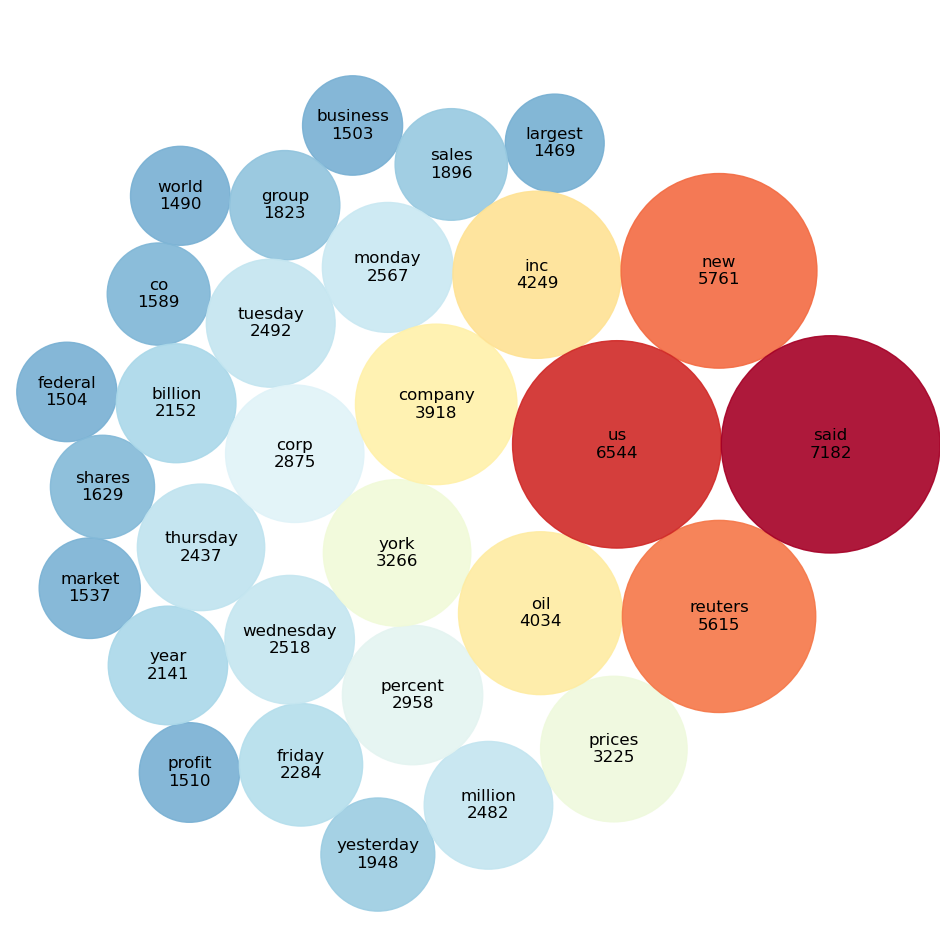

In [45]:
fig, ax = plt.subplots(figsize=(12,12), facecolor='white')
ax.axis('off')
lim = max(max(abs(circle.x)+circle.r, abs(circle.y)+circle.r,) for circle in circles)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

# list of labels
labels = list(business_words.sort_values(by='Count', ascending=False)['Word'][0:30])
counts = list(business_words.sort_values(by='Count', ascending=False)['Count'][0:30])
labels.reverse()
counts.reverse()

#print circles
for circle, label, count in zip(circles, labels, counts):
    x, y, r = circle
    ax.add_patch(plt.Circle((x, y), r, alpha=0.9, color = color_dict.get(count)))
    plt.annotate(label +'\n'+ str(count), (x,y), size=12, va='center', ha='center')
plt.xticks([])
plt.yticks([])
plt.show()

#### Science/Technology Circles

In [46]:
# compute circle positions:
circles = circlify.circlify(science_tech_words.sort_values(by='Count', ascending=False)['Count'][0:30].tolist(),
                            show_enclosure=False,
                            target_enclosure=circlify.Circle(x=0, y=0))

n = sports_words.sort_values(by='Count', ascending=False)['Count'][0:30].max()
color_dict = get_colordict('RdYlBu_r',n ,1)



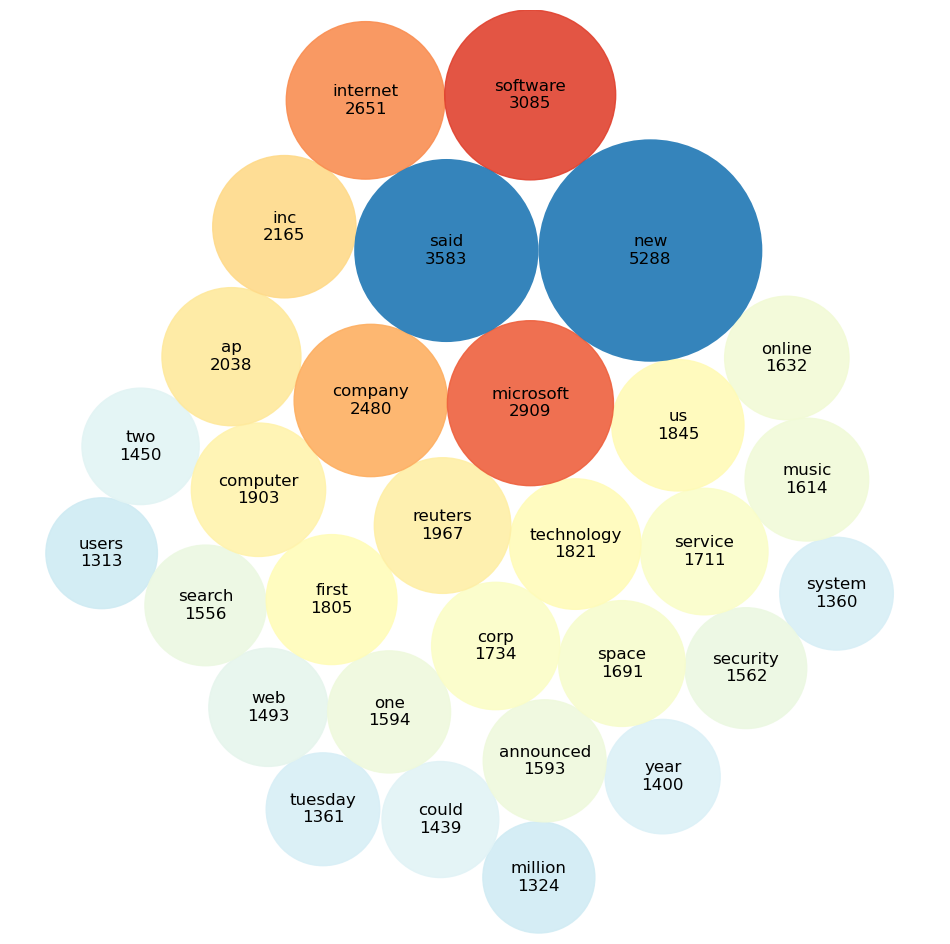

In [47]:
fig, ax = plt.subplots(figsize=(12,12), facecolor='white')
ax.axis('off')
lim = max(max(abs(circle.x)+circle.r, abs(circle.y)+circle.r,) for circle in circles)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

# list of labels
labels = list(science_tech_words.sort_values(by='Count', ascending=False)['Word'][0:30])
counts = list(science_tech_words.sort_values(by='Count', ascending=False)['Count'][0:30])
labels.reverse()
counts.reverse()

#print circles
for circle, label, count in zip(circles, labels, counts):
    x, y, r = circle
    ax.add_patch(plt.Circle((x, y), r, alpha=0.9, color = color_dict.get(count)))
    plt.annotate(label +'\n'+ str(count), (x,y), size=12, va='center', ha='center')
plt.xticks([])
plt.yticks([])
plt.show()

- These circle plots just show the same data as the bar plots, just a different perspective

### Word Clouds

<a id="Word_Clouds"></a>

In [48]:
# pip install wordcloud

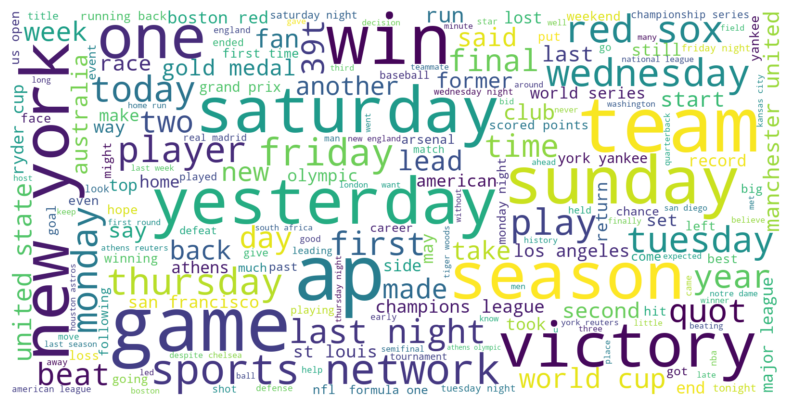

In [49]:
#sports
#concatenate all text from the `cleaned_description` column
sports_all_text = ' '.join(sports_df_train['cleaned_description'])

#create a WordCloud object
sports_wordcloud = WordCloud(width=1600, height=800, random_state=21, max_font_size=160, background_color='white').generate(sports_all_text)

#display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(sports_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

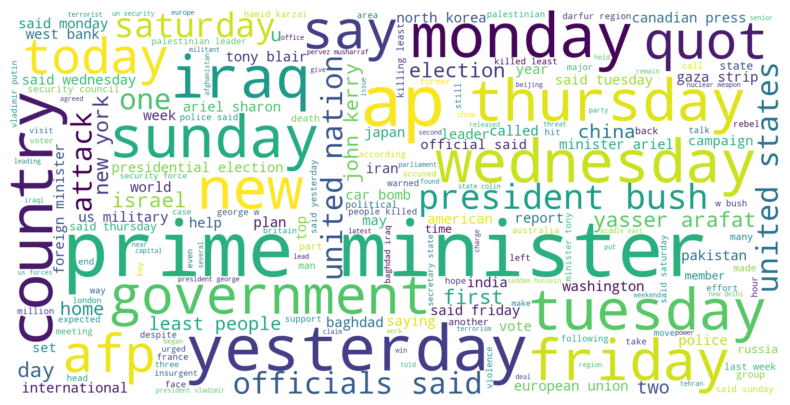

In [50]:
#world news
#concatenate all text from the `cleaned_description` column
world_news_all_text = ' '.join(world_news_df_train['cleaned_description'])

#create WordCloud object
world_wordcloud = WordCloud(width=1600, height=800, random_state=21, max_font_size=160, background_color='white').generate(world_news_all_text)

#display word cloud
plt.figure(figsize=(10, 5))
plt.imshow(world_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

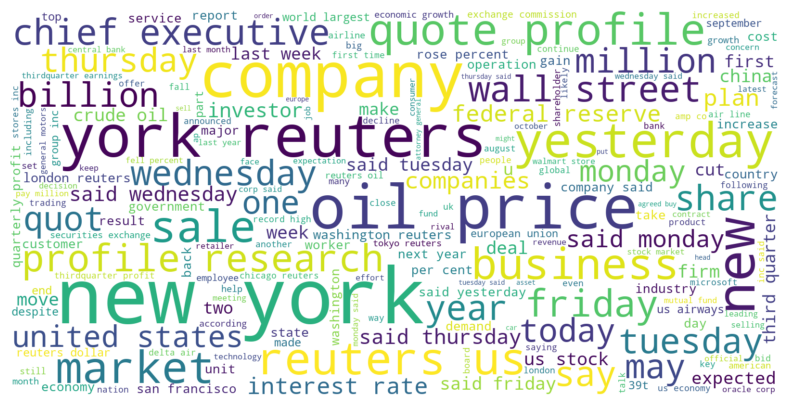

In [51]:
#business
#concatenate all text from the cleaned_description column
business_all_text = ' '.join(business_df_train['cleaned_description'])

#create a WordCloud object
business_wordcloud = WordCloud(width=1600, height=800, random_state=21, max_font_size=160, background_color='white').generate(business_all_text)

#display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(business_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

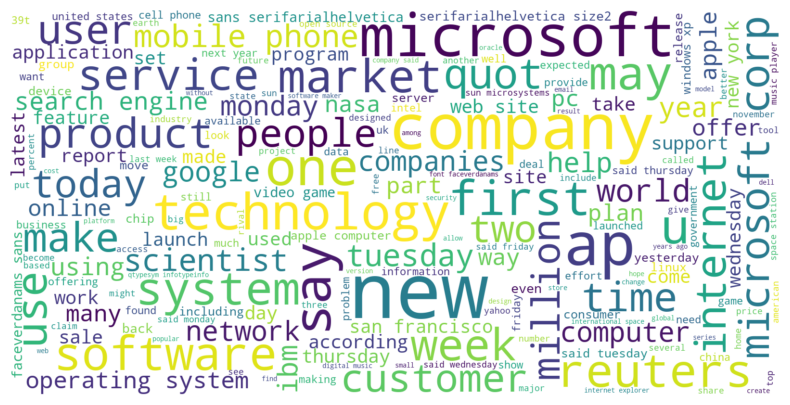

In [52]:
#science
#concatenate all text from the cleaned_description column
science_all_text = ' '.join(science_df_train['cleaned_description'])

#create a WordCloud object
science_wordcloud = WordCloud(width=1600, height=800, random_state=21, max_font_size=160, background_color='white').generate(science_all_text)

#display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(science_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Sentiment Analysis

- Out of curiosity, we felt it might be interesting to compute the sentiment scores of the article descriptions and their titles. No real hypothesis here, just looking to see if there was any insights we could find.

In [53]:
#download in the event package isnt installed
#nltk.download('vader_lexicon')

In [54]:
#initialize SentimentIntensityAnalyzer()
sentiment = SentimentIntensityAnalyzer()

#apply the sentiment analyzer to `clean_description`
df_train['desc_sentiment_scores'] = df_train['cleaned_description'].apply(lambda description: sentiment.polarity_scores(description))
# apply the sentiment analyzer to `cleaned_title`
df_train['title_sentiment_scores'] = df_train['cleaned_title'].apply(lambda title: sentiment.polarity_scores(title))


#extract  compound sentiment score from the title sentiment scores
df_train['des_compound_score'] = df_train['desc_sentiment_scores'].apply(lambda scores: scores['compound'])
# extract  compound sentiment score from the title sentiment scores
df_train['title_compound_score'] = df_train['title_sentiment_scores'].apply(lambda scores: scores['compound'])



In [55]:
df_train

,description,label,title,cleaned_description,cleaned_title,desc_sentiment_scores,title_sentiment_scores,des_compound_score,title_compound_score
0,b'AMD #39;s new dual-core Opteron chip is desi...,3,b'AMD Debuts Dual-Core Opteron Processor',amd new dualcore opteron chip designed mainly ...,amd debuts dualcore opteron processor,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.0
1,b'Reuters - Major League Baseball\\Monday anno...,1,"b""Wood's Suspension Upheld (Reuters)""",reuters major league baseballmonday announced ...,woods suspension upheld reuters,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.0
2,b'President Bush #39;s quot;revenue-neutral q...,2,b'Bush reform may have blue states seeing red',president bush quotrevenueneutral quot tax ref...,bush reform may blue states seeing red,"{'neg': 0.115, 'neu': 0.78, 'pos': 0.105, 'com...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",-0.0772,0.0
3,b'Britain will run out of leading scientists u...,3,"b""'Halt science decline in schools'""",britain run leading scientists unless science ...,halt science decline schools,"{'neg': 0.0, 'neu': 0.78, 'pos': 0.22, 'compou...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.4767,0.0
4,"b'London, England (Sports Network) - England m...",1,b'Gerrard leaves practice',london england sports network england midfield...,gerrard leaves practice,"{'neg': 0.102, 'neu': 0.679, 'pos': 0.219, 'co...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.4767,0.0
...,...,...,...,...,...,...,...,...,...
119995,b'Ivan Ljubicic edged No. 7 seed Joachim Johan...,1,"b'Agassi, Ljubicic advance in Madrid Masters'",ivan ljubicic edged 7 seed joachim johansson t...,agassi ljubicic advance madrid masters,"{'neg': 0.0, 'neu': 0.868, 'pos': 0.132, 'comp...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.2263,0.0
119996,b'MANAMA: A \\$1.3 billion (BD491 million) com...,2,"b'\\$1.3 billion power plant will generate 3,5...",manama 13 billion bd491 million combined power...,13 billion power plant generate 3500 jobs,"{'neg': 0.0, 'neu': 0.896, 'pos': 0.104, 'comp...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.2732,0.0
119997,"b'And lo, the hawk begat the dove. At least th...",0,b'Last man standing',lo hawk begat dove least one imagines private ...,last man standing,"{'neg': 0.0, 'neu': 0.865, 'pos': 0.135, 'comp...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.5574,0.0
119998,"b'West Palm Beach, FL (Sports Network) - Tom L...",1,b'Report: Lehman named Ryder Cup captain',west palm beach fl sports network tom lehman n...,report lehman named ryder cup captain,"{'neg': 0.0, 'neu': 0.872, 'pos': 0.128, 'comp...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.4215,0.0


#### Sentiment Analysis - Plots

<a id="Sentiment_Analysis"></a>

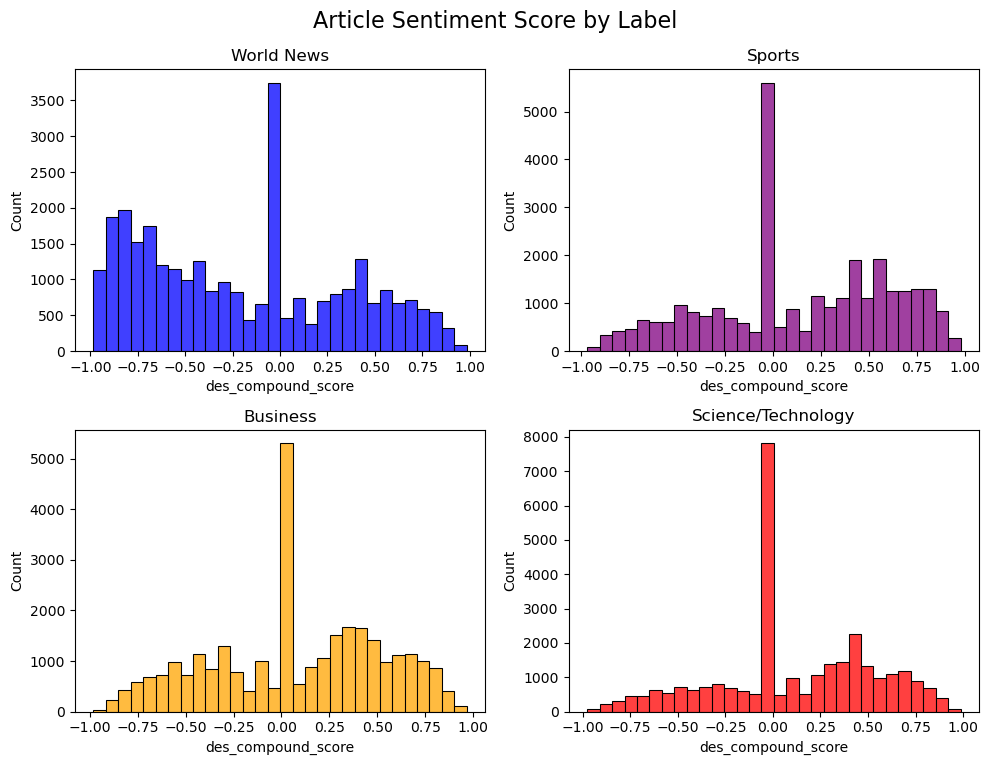

In [56]:
#setting up subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

#plot histograms for each label
sns.histplot(df_train[df_train['label']==0]['des_compound_score'], bins=30, color='blue', ax=axes[0, 0])
axes[0, 0].set_title('World News')

sns.histplot(df_train[df_train['label']==1]['des_compound_score'], bins=30, color='purple', ax=axes[0, 1])
axes[0, 1].set_title('Sports')

sns.histplot(df_train[df_train['label']==2]['des_compound_score'], bins=30, color='orange', ax=axes[1, 0])
axes[1, 0].set_title('Business')

sns.histplot(df_train[df_train['label']==3]['des_compound_score'], bins=30, color='red', ax=axes[1, 1])
axes[1, 1].set_title('Science/Technology')

#layout
plt.tight_layout()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

#all plots title
plt.suptitle('Article Sentiment Score by Label', fontsize=16)

#show the plot
plt.show()

The sentiment analysis from the nltk library computes three scores for negativity, neutral, and positivity. These three scores are then calculated together to get the compound score.

The above plots show the compound scores for all four article types. We can see that the World News articles had a lower amount of neutral articles and a higher number of articles that were negative than the other categories.

Sports articles had more positive articles than negative ones. This trend is mostly similar for the Business article category.

Science and technology had significantly more neutral articles than the other categories.

Not much can really be gleaned from this.

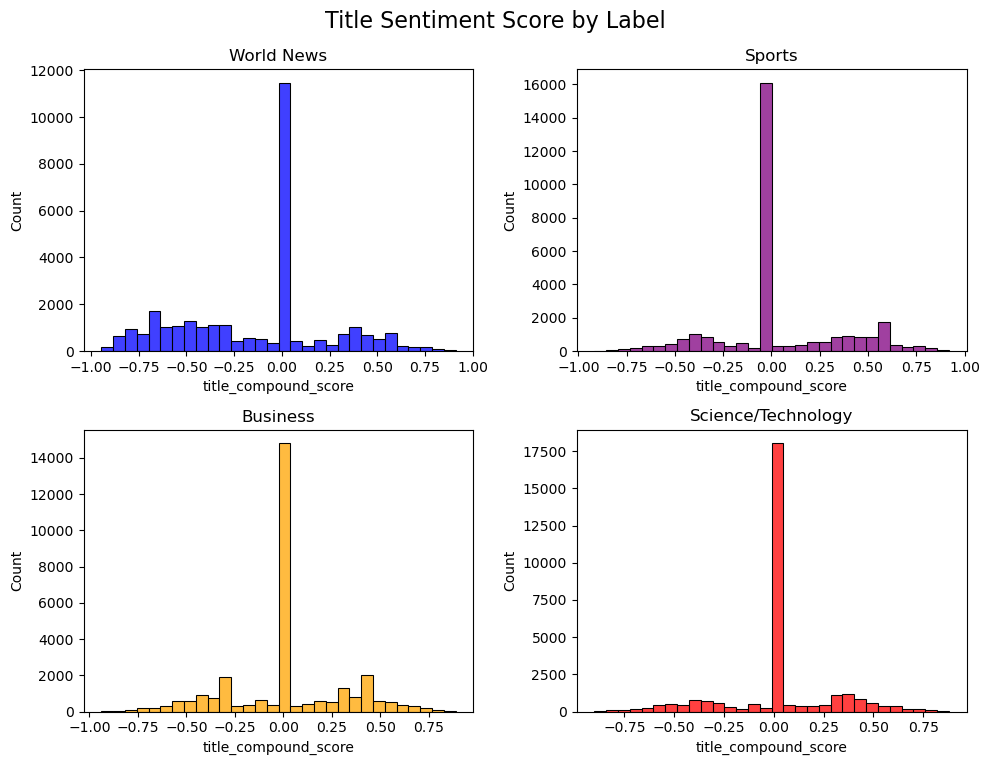

In [58]:
#subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

#plot histograms for each label
sns.histplot(df_train[df_train['label']==0]['title_compound_score'], bins=30, color='blue', ax=axes[0, 0])#, kde=True)
axes[0, 0].set_title('World News')

sns.histplot(df_train[df_train['label']==1]['title_compound_score'], bins=30, color='purple', ax=axes[0, 1])#, kde=True)
axes[0, 1].set_title('Sports')

sns.histplot(df_train[df_train['label']==2]['title_compound_score'], bins=30, color='orange', ax=axes[1, 0])#, kde=True)
axes[1, 0].set_title('Business')

sns.histplot(df_train[df_train['label']==3]['title_compound_score'], bins=30, color='red', ax=axes[1, 1])#, kde=True)
axes[1, 1].set_title('Science/Technology')

#layout
plt.tight_layout()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

#all plots title
plt.suptitle('Title Sentiment Score by Label', fontsize=16)

# Show the plot
plt.show()

Looking at the sentiment of just the titles, the World News titles followed the trend that the descriptions with more negative scores than positives, excluding the neutral ones.

The other article types mainly had neutral titles. Again, not much really can be learned from this.

<Axes: xlabel='label', ylabel='des_compound_score'>

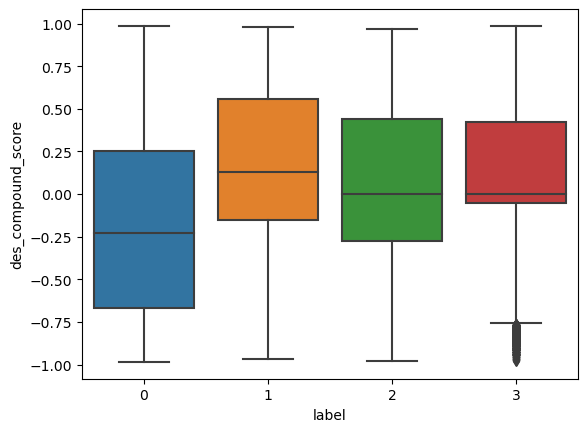

In [59]:
#boxplot of the description sentiment score by labels
sns.boxplot(x='label', y='des_compound_score', data=df_train)

<Axes: xlabel='label', ylabel='title_compound_score'>

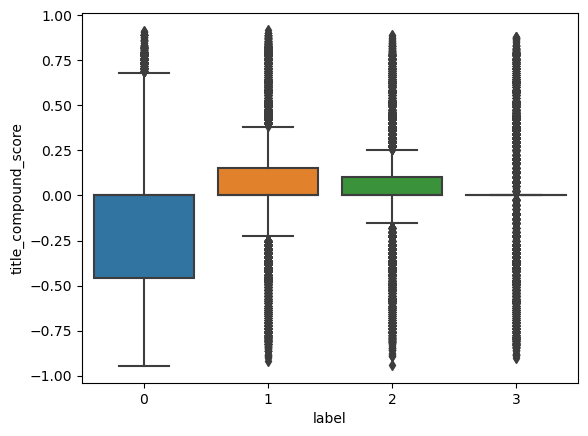

In [60]:
#boxplot of the title sentiment score by labels
sns.boxplot(x='label', y='title_compound_score', data=df_train)

### N-grams

<a id="N_grams"></a>

In [61]:
#function to find number of n-grams
def ngrams(tokens, n, top=10):
    #looping through tokens to create a list of n-grams
    n_grams = [' '.join(tokens[i:i+n]) for i in range(len(tokens)-n+1)]

    #counts the n_grams to find most frequent
    n_gram_counts = Counter(n_grams)

    #limits the to the designated top number of n_grams
    most_common_ngrams = n_gram_counts.most_common(top)

    return most_common_ngrams

In [62]:
#function for n_gram plot
def plot_n_grams(df, n="bi?", title="ENTER"):
    plt.figure(figsize=(10, 6))
    plt.barh(df['n_gram'], df['frequency'], color='skyblue')
    plt.title(f'Top {title} {n}-grams')
    plt.xlabel(f'{n}_gram')
    plt.ylabel('frequency')
    plt.show()

#### world news n-grams

In [63]:
#tokenizing all words
world_news_tokens = word_tokenize(world_news_all_text)

#creating world news bi-gram df
world_bi_grams_df = pd.DataFrame(ngrams(world_news_tokens, n=2, top=20), columns=['n_gram', 'frequency'])

world_bi_grams_df

,n_gram,frequency
0,prime minister,2188
1,officials said,881
2,united states,871
3,united nations,813
4,president bush,747
5,new york,625
6,yasser arafat,586
7,gaza strip,488
8,john kerry,487
9,said monday,456


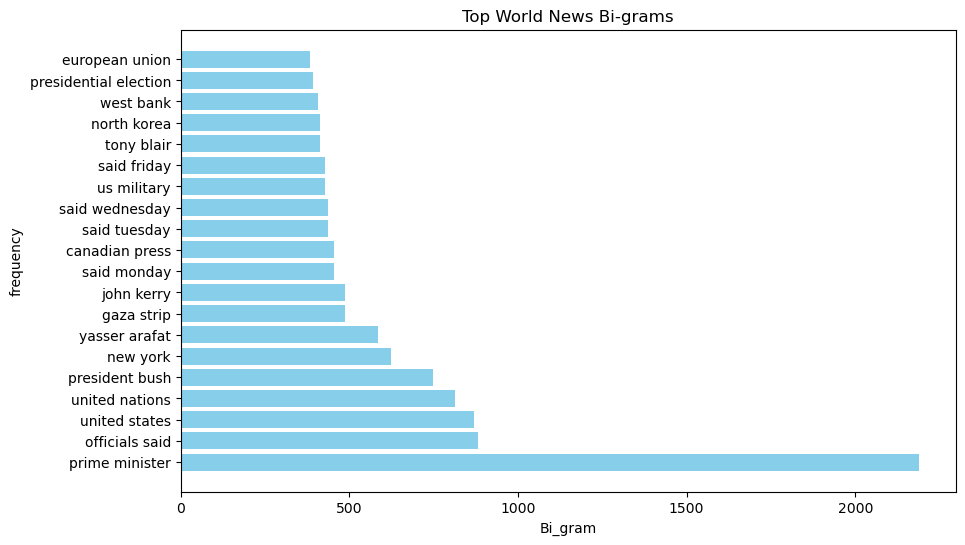

In [64]:
#plotting world news bi-grams
plot_n_grams(world_bi_grams_df, n='Bi',title="World News")

In [65]:
world_tri_grams_df = pd.DataFrame(ngrams(world_news_tokens, n=3, top=20), columns=['n_gram', 'frequency'])

world_tri_grams_df

,n_gram,frequency
0,prime minister ariel,369
1,minister ariel sharon,315
2,prime minister tony,284
3,minister tony blair,276
4,george w bush,268
5,president vladimir putin,233
6,secretary state colin,219
7,president george w,219
8,un security council,218
9,state colin powell,187


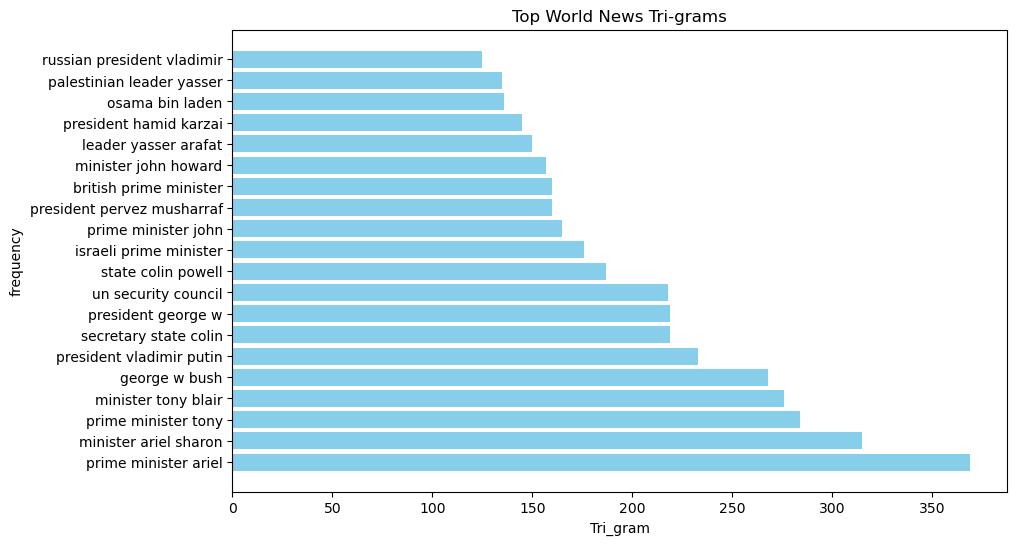

In [66]:
plot_n_grams(world_tri_grams_df, n='Tri', title="World News")

#### sports n-grams

In [67]:
#tokenizing all words in sports articles
sports_tokens = word_tokenize(sports_all_text)

#bi-grams for sports articles
sports_bi_grams_df = pd.DataFrame(ngrams(sports_tokens, n=2, top=20), columns=['n_gram', 'frequency'])

sports_bi_grams_df

,n_gram,frequency
0,new york,1599
1,sports network,1250
2,red sox,1016
3,last night,810
4,world cup,671
5,united states,543
6,manchester united,499
7,los angeles,479
8,champions league,475
9,gold medal,460


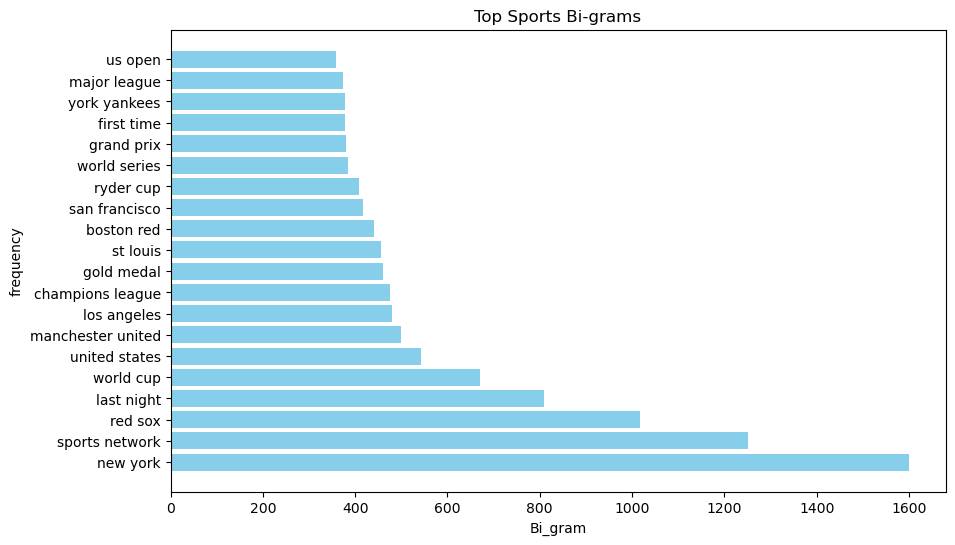

In [68]:
plot_n_grams(sports_bi_grams_df, n='Bi', title='Sports')

In [69]:
#tri-grams for sports articles
sports_tri_grams_df = pd.DataFrame(ngrams(sports_tokens, n=3, top=20), columns=['n_gram', 'frequency'])

sports_tri_grams_df

,n_gram,frequency
0,boston red sox,438
1,new york yankees,377
2,new york reuters,257
3,major league baseball,206
4,st louis cardinals,190
5,cbc sports online,168
6,san francisco giants,164
7,new england patriots,137
8,league championship series,137
9,world number one,123


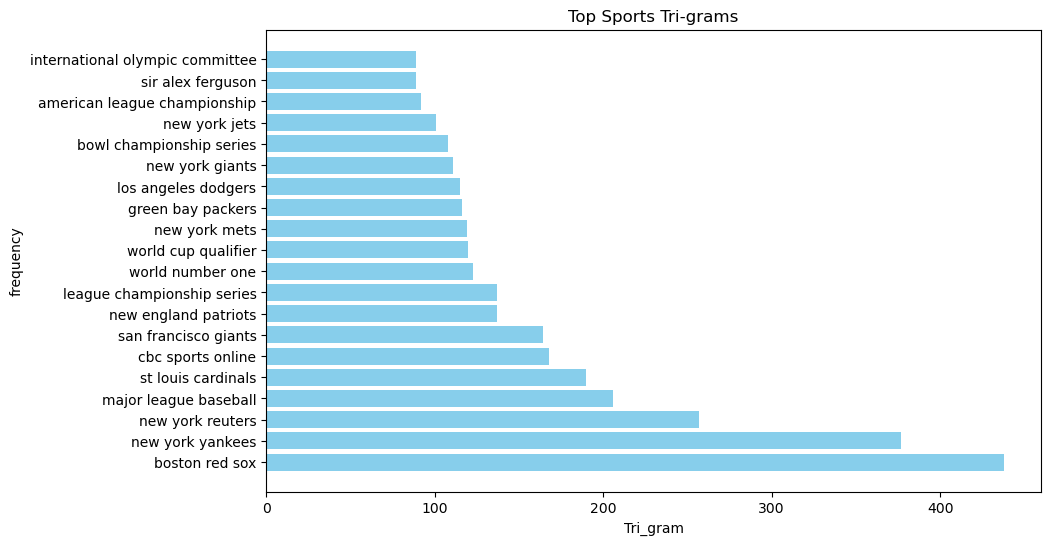

In [70]:
plot_n_grams(sports_tri_grams_df, n='Tri', title='Sports')

#### business n-grams

In [73]:
#tokenizing all words in sports articles
business_tokens = word_tokenize(business_all_text)

#bi-grams for sports articles
business_bi_grams_df = pd.DataFrame(ngrams(business_tokens, n=2, top=20), columns=['n_gram', 'frequency'])

business_bi_grams_df

,n_gram,frequency
0,new york,3237
1,oil prices,1947
2,york reuters,1843
3,reuters us,1026
4,quote profile,954
5,profile research,952
6,chief executive,847
7,wall street,823
8,united states,698
9,said monday,648


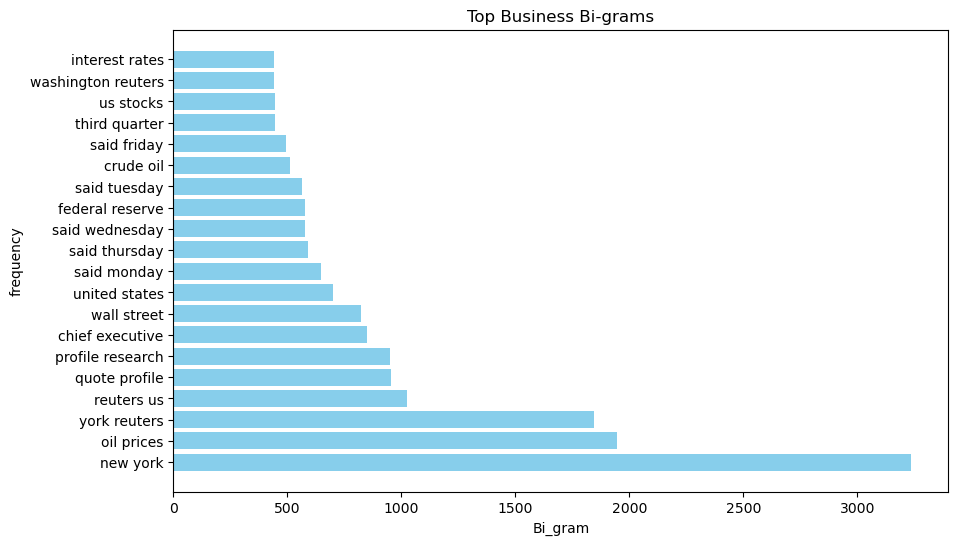

In [74]:
plot_n_grams(business_bi_grams_df, n='Bi', title='Business')

In [75]:
#tri-grams for sports articles
business_tri_grams_df = pd.DataFrame(ngrams(business_tokens, n=3, top=20), columns=['n_gram', 'frequency'])

business_tri_grams_df

,n_gram,frequency
0,new york reuters,1820
1,quote profile research,952
2,york reuters us,520
3,securities exchange commission,313
4,reuters us stocks,299
5,reuters oil prices,282
6,delta air lines,242
7,crude oil prices,188
8,washington reuters us,180
9,walmart stores inc,178


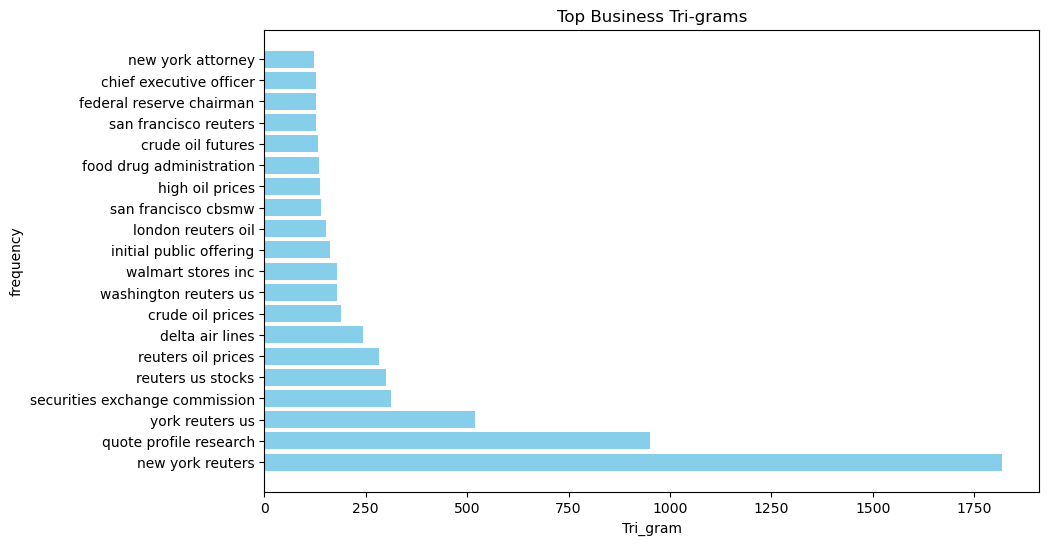

In [76]:
plot_n_grams(business_tri_grams_df, n='Tri', title='Business')

#### Science n-grams

In [77]:
#tokenizing all words in sports articles
science_tokens = word_tokenize(science_all_text)

#bi-grams for sports articles
science_bi_grams_df = pd.DataFrame(ngrams(science_tokens, n=2, top=20), columns=['n_gram', 'frequency'])

science_bi_grams_df

,n_gram,frequency
0,microsoft corp,648
1,operating system,466
2,search engine,439
3,new york,422
4,san francisco,411
5,faceverdanams sans,401
6,sans serifarialhelvetica,401
7,serifarialhelvetica size2,401
8,said tuesday,395
9,windows xp,386


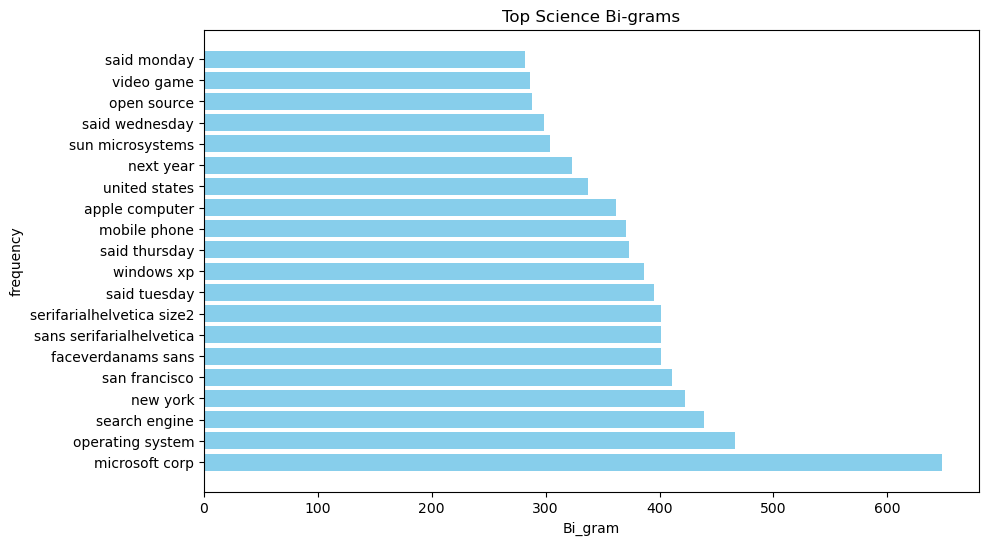

In [78]:
plot_n_grams(science_bi_grams_df, n='Bi', title='Science')

In [79]:
#tri-grams for sports articles
science_tri_grams_df = pd.DataFrame(ngrams(science_tokens, n=3, top=20), columns=['n_gram', 'frequency'])

science_tri_grams_df

,n_gram,frequency
0,faceverdanams sans serifarialhelvetica,401
1,sans serifarialhelvetica size2,401
2,font faceverdanams sans,235
3,international space station,232
4,serifarialhelvetica size2 color666666bthe,186
5,size2 color666666bthe washington,184
6,color666666bthe washington postbfont,184
7,service pack 2,167
8,apple computer inc,147
9,advanced micro devices,136


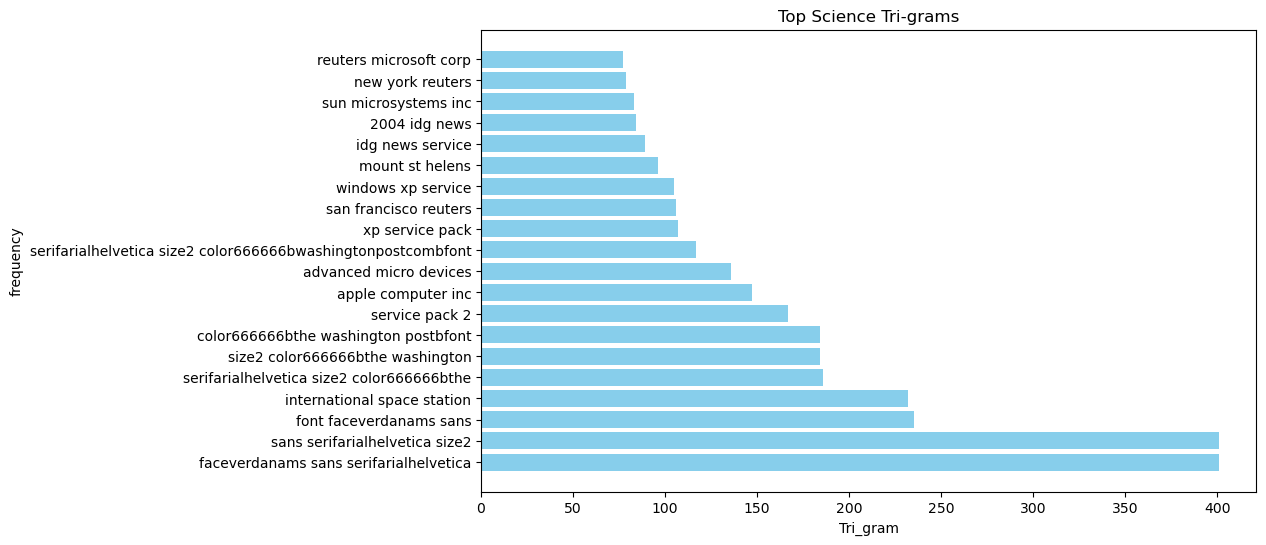

In [80]:
plot_n_grams(science_tri_grams_df, n='Tri', title='Science')

- Looking at the n-grams for the article types, we can see that there is more division between them. The terms are in line with what you would expect for each type of article. This leads to the positive idea that the models will have success in classifying the types of articles.

## Baseline Models

<a id="Baseline_Model"></a>

#### Re-cleaning datasets to remove all non letters

In [197]:
#function to convert a raw text from loaded dataset to string

def clean_words_only_letters(raw_description):

    #remove HTML
    description_text = BeautifulSoup(raw_description).get_text()

    #remove non-letters
    letters_only = re.sub(r'[^a-zA-Z]', ' ', description_text)

    #removing html artifact 39s from when apostrophe errored
    final_clean = re.sub(r'39s', '', letters_only)

    #convert to lower case, split into individual words.
    words = final_clean.lower().split()

    #setting stop words
    stops = set(stopwords.words('english'))

    #remove stop words.
    meaningful_words = [w for w in words if w not in stops]

    #join the words into one string, return result.
    return(" ".join(meaningful_words))

In [198]:
#data import from provided code
import tensorflow_datasets as tfds
train_data, test_data = tfds.load(
  'ag_news_subset',
  split = ['train', 'test'],
  batch_size = -1
)
df_train_2 = pd.DataFrame(train_data)
df_test_2 = pd.DataFrame(test_data)

In [199]:
#applying function over description column creating new column
df_train_2['cleaned_description'] = df_train_2['description'].apply(clean_words_only_letters)
df_train_2['cleaned_title'] = df_train_2['title'].apply(clean_words_only_letters)

/var/folders/9l/8vvnk63j2j9f_hg8yf6z57v80000gn/T/ipykernel_3947/135601901.py:15: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  description_text = BeautifulSoup(raw_description).get_text()
/var/folders/9l/8vvnk63j2j9f_hg8yf6z57v80000gn/T/ipykernel_3947/135601901.py:15: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  description_text = BeautifulSoup(raw_description).get_text()


#### creating training set with all labels

In [200]:
#labeling all non-sports articles as 0
df_train_2['label'] = df_train_2['label'].map(lambda x: 1 if x == 1 else 0)

In [201]:
#creating y_train target variable
y_train = df_train_2['label']

#### <u>Cleaning Test Set</u>
- test set cleaned the same way the training set was

In [202]:
#applying function over description column creating new column
df_test_2['cleaned_description'] = df_test_2['description'].apply(clean_words_only_letters)
df_test_2['cleaned_title'] = df_test_2['title'].apply(clean_words_only_letters)

/var/folders/9l/8vvnk63j2j9f_hg8yf6z57v80000gn/T/ipykernel_3947/135601901.py:15: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  description_text = BeautifulSoup(raw_description).get_text()
/var/folders/9l/8vvnk63j2j9f_hg8yf6z57v80000gn/T/ipykernel_3947/135601901.py:15: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  description_text = BeautifulSoup(raw_description).get_text()


### Creating test set from all labels

In [203]:
df_test_2['label'] = df_test_2['label'].map(lambda x: 1 if x == 1 else 0)

#checking to see the proportion of the sports label
sports_article_porportion = len(df_test_2[df_test_2['label']==1])/len(df_test)

print(f'Proportion of sports articles in dataset: {sports_article_porportion}')

Proportion of sports articles in dataset: 0.25


In [204]:
y_test = df_test_2['label']

#### Logistic Regression

##### **ngram - 1**

In [205]:
start_time = time.time()

#creating tfidf from data
tfidf_1 = TfidfVectorizer(max_features=10000,
                        ngram_range=(1,1),
                        stop_words='english',
                        max_df = 1.0)

#fit and trasnforming vectorizer to training data
X_train_1 = tfidf_1.fit_transform(df_train_2['cleaned_description'])

#applying transform to test data
X_test_1 = tfidf_1.transform(df_test_2['cleaned_description'])

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

Elapsed time: 0.8760 seconds


- We opted to do pca transformation on the tfidf set. Since there was some difference in the top words between the articles, having 10k features in the model seems like it would be overkill. We will start with 250 components and go from there.

- looking at the F1 score we can see a generally good model was fit from our data. The fact that the model was able to obtain an f1 score with an imbalanced data set is great for a simple model.

In [206]:
start_time = time.time()

#fitting logistic regression model with l1 regularization
lr_1_tfidf = LogisticRegression(penalty='l1', solver='liblinear')

#fitting model
lr_1_tfidf.fit(X_train_1, y_train)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

Elapsed time: 0.3074 seconds


In [207]:
start_time = time.time()

#predictions
lr_1_tfidf_preds = lr_1_tfidf.predict(X_test_1)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

Elapsed time: 0.0012 seconds


In [208]:
#classification report to see many metrics
lr_1_tfidf_classification_rep = classification_report(y_test, lr_1_tfidf_preds)

print("Logisti Regresion Classification Report:")
print(lr_1_tfidf_classification_rep)

Logisti Regresion Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      5700
           1       0.96      0.94      0.95      1900

    accuracy                           0.98      7600
   macro avg       0.97      0.96      0.97      7600
weighted avg       0.98      0.98      0.98      7600



In [209]:
f1_score(y_test, lr_1_tfidf_preds)

0.9511677282377919

In [210]:
#function to find top coefficients
def model_coef(model, tfidf, n=25):
    #finding model coefficients
    coefficients = model.coef_
    
    #getting feature names
    feature_names = np.array(tfidf.get_feature_names_out())

    # Get indices of top n features
    top_feature_indices = coefficients.argsort()[0, -n:][::-1]

    #top features from pca reduced tfidf
    top_coeff_words = feature_names[top_feature_indices]
    
    print(top_coeff_words)
    

In [327]:
#printing top 50 model coefficients 
model_coef(lr_1_tfidf, tfidf_1, n=50)

['cup' 'coach' 'nascar' 'sports' 'nhl' 'hendrick' 'cricket' 'quarterback'
 'kobe' 'stadium' 'sox' 'manchester' 'notre' 'formula' 'nba' 'football'
 'auburn' 'teams' 'olympics' 'rugby' 'doping' 'pitcher' 'baseball'
 'league' 'prix' 'olympic' 'cleveland' 'mets' 'team' 'nfl' 'wenger'
 'season' 'turin' 'redskins' 'ncaa' 'pacers' 'striker' 'manager' 'coaches'
 'bowl' 'basketball' 'champion' 'tennis' 'defensive' 'club' 'coaching'
 'championship' 'caminiti' 'players' 'boxing']


In [316]:
#function to show misclassified articles
def classification_examples(y_test, y_pred, X_test):

    #finding where model misclassified on testing set
    misclassified_indicies = (y_test != y_pred)
    
    #creating subset for misclassified articles
    misclass_examples = X_test[misclassified_indicies]
    
    #creating labels for misclassified answers
    answer_label = y_test[misclassified_indicies]
    
    #creating label for what was predicted
    predicted_label = y_pred[misclassified_indicies]
    
    #creating subset of mislabled classes
    shortened_misclass_examples = misclass_examples[:5]
    
    print(f'Number of misclassifications: {len(misclass_examples)}\n')

    #loop for print out first 5 misclassified article
    #print the predictions and answer lables
    for i in range(len(shortened_misclass_examples)):
        print(f'{i+1} - {shortened_misclass_examples.iloc[i]}')
        print(f'Real Label: {answer_label.iloc[i]}, Predicted Label: {predicted_label[i]}')
        print('\n')
    

    

In [317]:
classification_examples(y_test, lr_1_tfidf_preds, df_test_2['cleaned_description'])

Number of misclassifications: 184

1 - sebastian sainsbury warned leeds united chiefs today face stark choice accepting million bid selling elland road
Real Label: 1, Predicted Label: 0


2 - probably heard one toughest endurance sports around deca ironman km swimming immediately followed km bicycle ride km run currently world record stands hours held german housewife nobody else ever finished course hours
Real Label: 0, Predicted Label: 1


3 - three banks go high court london seeking ruling could lead bernie ecclestone losing control formula one racing
Real Label: 0, Predicted Label: 1


4 - everton chairman bill kenwright plans russian revolution goodison park may thawed cold war director paul gregg
Real Label: 1, Predicted Label: 0


5 - san diego wake another downgrading san diego credit rating mayor dick murphy today reassured public city fiscally sound
Real Label: 0, Predicted Label: 1




##### **ngram - 2**

In [212]:
start_time = time.time()

#creating tfidf from data
tfidf_2 = TfidfVectorizer(max_features=10000,
                        ngram_range=(1,2),
                        stop_words='english',
                        max_df = 1.0)

#fit and trasnforming vectorizer to training data
X_train_2 = tfidf_2.fit_transform(df_train_2['cleaned_description'])

#applying transform to test data
X_test_2 = tfidf_2.transform(df_test_2['cleaned_description'])

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

Elapsed time: 3.3269 seconds


###### pca transformation

In [102]:
start_time = time.time()

#conducting pca feature reduction
#upping the components to 500 as we added n-grams to 2
pca_2 = TruncatedSVD(n_components=500)

#reducing the features on the datasets
X_train_2_pca = pca_2.fit_transform(X_train_2)
X_test_2_pca = pca_2.transform(X_test_2)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

Elapsed time: 15.1678 seconds


In [103]:
start_time = time.time()

#instantiating logisitic regression model
lr_2 = LogisticRegression(penalty='l1', solver='liblinear')

#fitting model
lr_2.fit(X_train_2_pca, y_train)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")



Elapsed time: 11.9799 seconds


In [104]:
start_time = time.time()

#preds
lr_2_preds = lr_2.predict(X_test_2_pca)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

Elapsed time: 0.0111 seconds


In [ ]:
lr_2_classification_rep = classification_report(y_test, lr_2_preds)

print("Logisti Regresion Classification Report:")
print(lr_2_classification_rep)

Logisti Regresion Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5700
           1       0.95      0.94      0.94      1900

    accuracy                           0.97      7600
   macro avg       0.96      0.96      0.96      7600
weighted avg       0.97      0.97      0.97      7600



In [154]:
round(f1_score(y_test, lr_2_preds),4)

0.94

###### non-pca transformation

In [213]:
start_time = time.time()

#instantiating logisitic regression model
lr_2_tfidf = LogisticRegression(penalty='l1', solver='liblinear')

#fitting model
lr_2_tfidf.fit(X_train_2, y_train)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")



Elapsed time: 0.3510 seconds


In [214]:
start_time = time.time()

#preds
lr_2_tfidf_preds = lr_2_tfidf.predict(X_test_2)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

Elapsed time: 0.0012 seconds


In [215]:
lr_2_tfidf_classification_rep = classification_report(y_test, lr_2_tfidf_preds)

print("Logisti Regresion Classification Report:")
print(lr_2_tfidf_classification_rep)

Logisti Regresion Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      5700
           1       0.96      0.94      0.95      1900

    accuracy                           0.98      7600
   macro avg       0.97      0.97      0.97      7600
weighted avg       0.98      0.98      0.98      7600



In [216]:
round(f1_score(y_test, lr_2_tfidf_preds),4)

0.9517

In [217]:
model_coef(lr_2_tfidf, tfidf_2, n=50)

['cup' 'coach' 'nascar' 'cricket' 'nhl' 'hendrick' 'kobe' 'quarterback'
 'sports' 'stadium' 'basketball' 'sox' 'league' 'nba' 'formula' 'football'
 'prix' 'auburn' 'team' 'pitcher' 'olympics' 'teams' 'baseball'
 'championship' 'pacers' 'cleveland' 'wenger' 'mets' 'doping' 'season'
 'striker' 'rugby' 'olympic' 'nfl' 'bowl' 'turin' 'ncaa' 'manager'
 'redskins' 'defensive' 'bryant' 'coaches' 'patriots' 'champion' 'club'
 'caminiti' 'athletic' 'ticker' 'tennis' 'players']


In [318]:
classification_examples(y_test, lr_2_tfidf_preds, df_test_2['cleaned_description'])

Number of misclassifications: 182

1 - sebastian sainsbury warned leeds united chiefs today face stark choice accepting million bid selling elland road
Real Label: 1, Predicted Label: 0


2 - probably heard one toughest endurance sports around deca ironman km swimming immediately followed km bicycle ride km run currently world record stands hours held german housewife nobody else ever finished course hours
Real Label: 0, Predicted Label: 1


3 - three banks go high court london seeking ruling could lead bernie ecclestone losing control formula one racing
Real Label: 0, Predicted Label: 1


4 - everton chairman bill kenwright plans russian revolution goodison park may thawed cold war director paul gregg
Real Label: 1, Predicted Label: 0


5 - big fish like richie sexson still looking work prizes like tim hudson dangled market orioles remain hopeful bag big catch
Real Label: 1, Predicted Label: 0




- There was a very slight improvement on the 1-ngram model, just by 1 point on the F1 score

#### logistic regression - balanced class weight

Because we have unbalanced classes, sports articles is .25% of the entire dataset, it would be a good idea to see how the model reacts when the classes weights are balanced

In [218]:
start_time = time.time()

#instantiating logisitic regression model
lr_3 = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced')

#fitting model
lr_3.fit(X_train_2, y_train)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

Elapsed time: 0.3454 seconds


In [219]:
start_time = time.time()

#preds
lr_3_preds = lr_3.predict(X_test_2)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

Elapsed time: 0.0017 seconds


In [220]:
#creating classification report
lr_3_classification_rep = classification_report(y_test, lr_3_preds)

print("Logisti Regresion Classification Report:")
print(lr_3_classification_rep)

Logisti Regresion Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      5700
           1       0.94      0.97      0.96      1900

    accuracy                           0.98      7600
   macro avg       0.97      0.98      0.97      7600
weighted avg       0.98      0.98      0.98      7600



In [221]:
round(f1_score(y_test, lr_3_preds),4)

0.9555

In [222]:
#top 50 model coeffients
model_coef(lr_3, tfidf_2, n=50)

['cup' 'coach' 'nascar' 'cricket' 'sports' 'nhl' 'hendrick' 'stadium'
 'quarterback' 'sox' 'formula' 'football' 'basketball' 'kobe' 'league'
 'olympics' 'nba' 'championship' 'baseball' 'team' 'pitcher' 'prix'
 'auburn' 'olympic' 'teams' 'nfl' 'season' 'doping' 'mets' 'cleveland'
 'bryant' 'pacers' 'striker' 'turin' 'tennis' 'redskins' 'expos'
 'champion' 'ncaa' 'motorsport' 'rugby' 'manager' 'yankees' 'players'
 'athletic' 'club' 'wenger' 'bowl' 'notre dame' 'coaches']


In [319]:
#looking at 3rd logistic regression misclassified articles
classification_examples(y_test, lr_3_preds, df_test_2['cleaned_description'])

Number of misclassifications: 172

1 - associated press curt anderson
Real Label: 0, Predicted Label: 1


2 - columbia c hurricane watch issued south carolina coast saturday forecasters predicted tropical storm gaston would make landfall near charleston sunday night
Real Label: 0, Predicted Label: 1


3 - sebastian sainsbury warned leeds united chiefs today face stark choice accepting million bid selling elland road
Real Label: 1, Predicted Label: 0


4 - probably heard one toughest endurance sports around deca ironman km swimming immediately followed km bicycle ride km run currently world record stands hours held german housewife nobody else ever finished course hours
Real Label: 0, Predicted Label: 1


5 - three banks go high court london seeking ruling could lead bernie ecclestone losing control formula one racing
Real Label: 0, Predicted Label: 1




- There was a reduction in precision, but an increase in recall. The F1 score increased marginally with the balanced classes model feature.

#### Random Forest

##### very basic RF model - with ngram 1

With the random forest model, we moved away from the PCA reducted feature set as the PCA feature set took signigicant longer to run and had worse results

In [229]:
start_time = time.time()

# Initialize and train the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

#RF model fit
rf_classifier.fit(X_train_1, y_train)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

Elapsed time: 56.3051 seconds


In [230]:
start_time = time.time()

# Predict on the test set
rf_preds = rf_classifier.predict(X_test_1)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

Elapsed time: 0.4482 seconds


In [231]:
#rf model evaluation
classification_rep = classification_report(y_test, rf_preds)

print("\nClassification Report:")
print(classification_rep)


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      5700
           1       0.93      0.96      0.95      1900

    accuracy                           0.97      7600
   macro avg       0.96      0.97      0.96      7600
weighted avg       0.97      0.97      0.97      7600



In [232]:
f1_score(y_test, rf_preds)

0.9470129870129869

In [328]:
#creating feature df from of all tfidf features
feature_importances = pd.DataFrame({'Feature': tfidf_1.get_feature_names_out(), 'Importance': rf_classifier.feature_importances_})

#sorting top 20 features from tfidf
top_rf_features = feature_importances.sort_values(by='Importance', ascending=False).head(20)

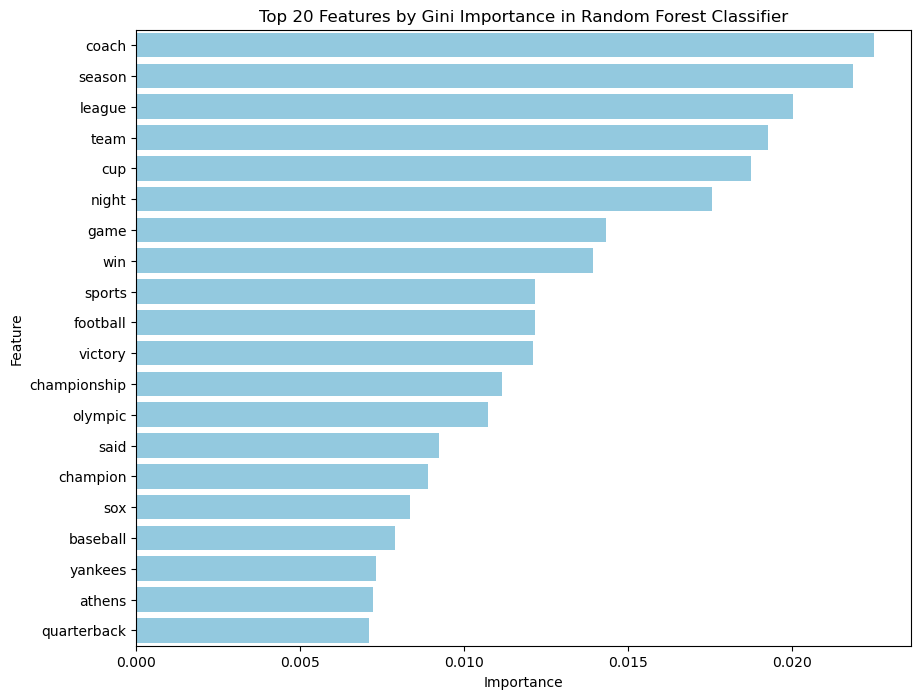

In [329]:
#ploing top features
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_rf_features, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Features by Gini Importance in Random Forest Classifier')
plt.show()


In [320]:
classification_examples(y_test, rf_preds, df_test_2['cleaned_description'])

Number of misclassifications: 204

1 - associated press curt anderson
Real Label: 0, Predicted Label: 1


2 - columbia c hurricane watch issued south carolina coast saturday forecasters predicted tropical storm gaston would make landfall near charleston sunday night
Real Label: 0, Predicted Label: 1


3 - china made debut last night club world leading economic powers asinternational pressure mounts change decade old currency peg critics accuse giving chinese products unfair competitive edge
Real Label: 0, Predicted Label: 1


4 - everton chairman bill kenwright plans russian revolution goodison park may thawed cold war director paul gregg
Real Label: 1, Predicted Label: 0


5 - last six years leominster blue devils endured thanksgiving day filled frustration instead celebration
Real Label: 1, Predicted Label: 0




##### very basic RF model - with ngram 2

In [235]:
# Initialize and train the Random Forest Classifier
rf_classifier_2 = RandomForestClassifier(random_state=42)

#RF model fit
rf_classifier_2.fit(X_train_2, y_train)

# Predict on the test set
rf_preds_2 = rf_classifier_2.predict(X_test_2)

In [236]:
#RF model evaluation
classification_rep_2 = classification_report(y_test, rf_preds_2)

print("\nClassification Report:")
print(classification_rep_2)


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      5700
           1       0.94      0.96      0.95      1900

    accuracy                           0.97      7600
   macro avg       0.96      0.97      0.97      7600
weighted avg       0.97      0.97      0.97      7600



In [326]:
f1_score(y_test, rf_preds_2)

0.9490462503266266

In [237]:
#creating feature df from of all tfidf features
feature_importances_2 = pd.DataFrame({'Feature': tfidf_2.get_feature_names_out(), 'Importance': rf_classifier_2.feature_importances_})

#sorting top 20 features from tfidf
top_rf_features_2 = feature_importances_2.sort_values(by='Importance', ascending=False).head(20)

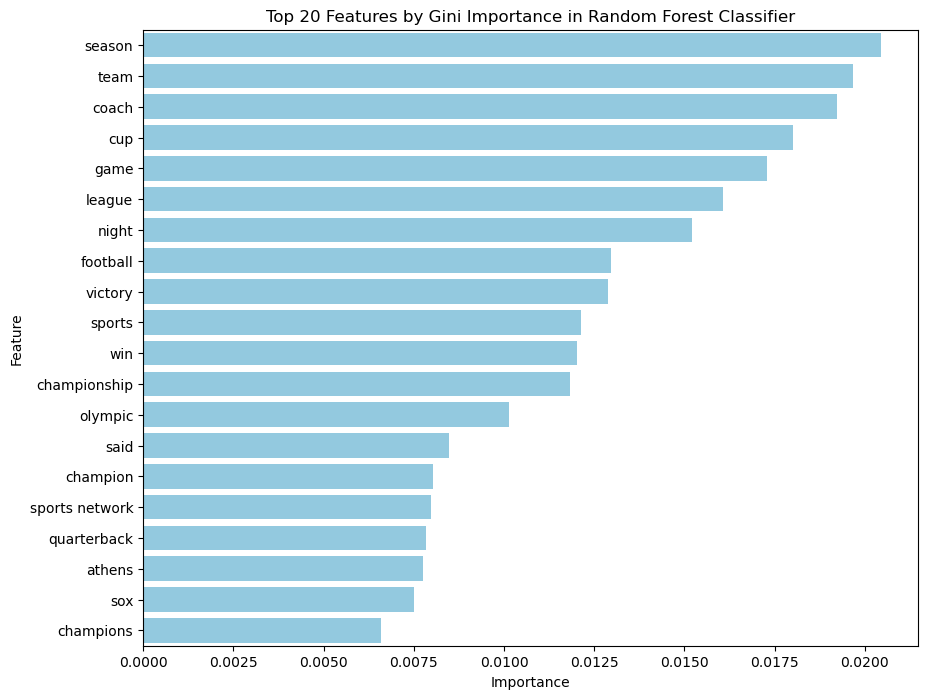

In [238]:
#ploing top features
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_rf_features_2, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Features by Gini Importance in Random Forest Classifier')
plt.show()


In [321]:
#misclassification for articles from random forest model 2
classification_examples(y_test, rf_preds_2, df_test_2['cleaned_description'])

Number of misclassifications: 195

1 - columbia c hurricane watch issued south carolina coast saturday forecasters predicted tropical storm gaston would make landfall near charleston sunday night
Real Label: 0, Predicted Label: 1


2 - sebastian sainsbury warned leeds united chiefs today face stark choice accepting million bid selling elland road
Real Label: 1, Predicted Label: 0


3 - china made debut last night club world leading economic powers asinternational pressure mounts change decade old currency peg critics accuse giving chinese products unfair competitive edge
Real Label: 0, Predicted Label: 1


4 - sammy rozenberg ap staff writer boxingscene staff writer boxingscene ready willing engage conversation post fight press conference following shane mosley winky wright rematch
Real Label: 1, Predicted Label: 0


5 - probably heard one toughest endurance sports around deca ironman km swimming immediately followed km bicycle ride km run currently world record stands hours held germa

## Deep Learning

<a id="Deep_Learning"></a>

In [239]:
#convert series into array data
df_train_np = df_train_2['cleaned_description'].values
df_test_np = df_test_2['cleaned_description'].values

#creating embedding value
max_tokens = 10000
max_sequence_length = 128
embedding_dims = 32
vectorize_layer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=max_sequence_length)
vectorize_layer.adapt(df_train_np)

In [240]:
#create model
model = Sequential()
model.add(vectorize_layer)
model.add(Embedding(max_tokens+1, output_dim=embedding_dims))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 128)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 128, 32)           320032    
                                                                 
 global_average_pooling1d (  (None, 32)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 24)                792       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 320849 (1.22 MB)
Trainable params: 320849 

In [241]:
start_time = time.time()

#compiling model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[Precision(), Recall()])

# Train model
model.fit(df_train_np, y_train, epochs=10, validation_data=(df_test_np, y_test))

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

Epoch 1/10
3750/3750 [==============================] - 5s 1ms/step - loss: 0.1427 - precision: 0.9539 - recall: 0.8254 - val_loss: 0.0681 - val_precision: 0.9508 - val_recall: 0.9653
Epoch 2/10
3750/3750 [==============================] - 4s 1ms/step - loss: 0.0561 - precision: 0.9617 - recall: 0.9716 - val_loss: 0.0628 - val_precision: 0.9511 - val_recall: 0.9716
Epoch 3/10
3750/3750 [==============================] - 4s 1ms/step - loss: 0.0472 - precision: 0.9655 - recall: 0.9789 - val_loss: 0.0672 - val_precision: 0.9638 - val_recall: 0.9516
Epoch 4/10
3750/3750 [==============================] - 4s 1ms/step - loss: 0.0412 - precision: 0.9679 - recall: 0.9825 - val_loss: 0.0632 - val_precision: 0.9491 - val_recall: 0.9716
Epoch 5/10
3750/3750 [==============================] - 4s 1ms/step - loss: 0.0361 - precision: 0.9712 - recall: 0.9844 - val_loss: 0.0672 - val_precision: 0.9615 - val_recall: 0.9584
Epoch 6/10
3750/3750 [==============================] - 4s 1ms/step - loss: 0.03

In [242]:
#predictions
nn_probs = model.predict(df_test_np)

238/238 [==============================] - 0s 386us/step


In [243]:
#converting probababilities into values using .5 as the threshold
nn_pred = (nn_probs > 0.5).astype(int).flatten()

nn_pred

array([1, 0, 0, ..., 0, 0, 1])

In [244]:
#viewing classification report
nn_class_rep=classification_report(y_test, nn_pred)

print(nn_class_rep)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      5700
           1       0.96      0.95      0.96      1900

    accuracy                           0.98      7600
   macro avg       0.97      0.97      0.97      7600
weighted avg       0.98      0.98      0.98      7600



In [245]:
f1_score(y_test, nn_pred)

0.9553028299391695

In [322]:
#misclassification of articles from feed forward neural net
classification_examples(y_test, nn_pred, df_test_2['cleaned_description'])

Number of misclassifications: 169

1 - associated press curt anderson
Real Label: 0, Predicted Label: 1


2 - probably heard one toughest endurance sports around deca ironman km swimming immediately followed km bicycle ride km run currently world record stands hours held german housewife nobody else ever finished course hours
Real Label: 0, Predicted Label: 1


3 - three banks go high court london seeking ruling could lead bernie ecclestone losing control formula one racing
Real Label: 0, Predicted Label: 1


4 - playing best golf year season ending tour championship tiger woods shoots leaving tied jay haas
Real Label: 1, Predicted Label: 0


5 - everton chairman bill kenwright plans russian revolution goodison park may thawed cold war director paul gregg
Real Label: 1, Predicted Label: 0




#### CNN Model

In [246]:
#instantiating a 1D cnn model
cnn = Sequential()
#adding the vecortized layer of data
cnn.add(vectorize_layer)
#setting the embedding inputs
cnn.add(Embedding(input_dim=10001, output_dim=64))
#adding a convolutional layer with 64 filters, window size of 5 and padding the same
cnn.add(Conv1D(filters=64, kernel_size=5, padding='same'))
cnn.add(Flatten())
cnn.add(Dense(1, activation='sigmoid'))
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 128)               0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 128, 64)           640064    
                                                                 
 conv1d (Conv1D)             (None, 128, 64)           20544     
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                 8193      
                                                                 
Total params: 668801 (2.55 MB)
Trainable params: 668801 (2.55 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [247]:
start_time = time.time()

#compiling model
cnn.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[Precision(), Recall()])
#setting early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

#fitting model with epochs of 100 and batchsize of 128
cnn.fit(df_train_np, y_train,
        epochs=50, batch_size=512,
        validation_data=(df_test_np, y_test),
        callbacks=[early_stopping])

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

Epoch 1/50
235/235 [==============================] - 8s 33ms/step - loss: 0.1483 - precision_1: 0.9555 - recall_1: 0.8059 - val_loss: 0.0668 - val_precision_1: 0.9494 - val_recall_1: 0.9668
Epoch 2/50
235/235 [==============================] - 8s 33ms/step - loss: 0.0481 - precision_1: 0.9671 - recall_1: 0.9716 - val_loss: 0.0660 - val_precision_1: 0.9648 - val_recall_1: 0.9521
Epoch 3/50
235/235 [==============================] - 8s 33ms/step - loss: 0.0374 - precision_1: 0.9736 - recall_1: 0.9784 - val_loss: 0.0690 - val_precision_1: 0.9598 - val_recall_1: 0.9553
Epoch 4/50
235/235 [==============================] - 8s 33ms/step - loss: 0.0291 - precision_1: 0.9795 - recall_1: 0.9833 - val_loss: 0.0757 - val_precision_1: 0.9547 - val_recall_1: 0.9532
Epoch 5/50
235/235 [==============================] - 8s 33ms/step - loss: 0.0196 - precision_1: 0.9869 - recall_1: 0.9895 - val_loss: 0.0904 - val_precision_1: 0.9481 - val_recall_1: 0.9526
Epoch 6/50
235/235 [=========================

In [248]:
cnn_probs = cnn.predict(df_test_np)

cnn_pred = (cnn_probs > 0.5).astype(int).flatten()

#creating classification report
cnn_class_rep = classification_report(y_test, cnn_pred)

print(cnn_class_rep)

238/238 [==============================] - 0s 896us/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5700
           1       0.95      0.95      0.95      1900

    accuracy                           0.97      7600
   macro avg       0.97      0.96      0.97      7600
weighted avg       0.97      0.97      0.97      7600



In [250]:
f1_score(y_test, cnn_pred)

0.9480348193088894

In [323]:
classification_examples(y_test, cnn_pred, df_test_2['cleaned_description'])

Number of misclassifications: 197

1 - years shawsheen tech greater lowell battled william j collins cup thanksgiving day
Real Label: 1, Predicted Label: 0


2 - electronic arts announced exclusive licensing relationships national football league players inc develop publish distribute interactive football games
Real Label: 1, Predicted Label: 0


3 - probably heard one toughest endurance sports around deca ironman km swimming immediately followed km bicycle ride km run currently world record stands hours held german housewife nobody else ever finished course hours
Real Label: 0, Predicted Label: 1


4 - three banks go high court london seeking ruling could lead bernie ecclestone losing control formula one racing
Real Label: 0, Predicted Label: 1


5 - brussels turkey recognize republic cyprus tacitly wants begin membership negotiations european union according draft document leaked monday
Real Label: 0, Predicted Label: 1




#### Simple RNN

In [251]:
#creating simple_rnn with required layers
embedding_dims = 128

simple_rnn = Sequential()
simple_rnn.add(vectorize_layer)
simple_rnn.add(Embedding(max_tokens + 1, embedding_dims))
simple_rnn.add(SimpleRNN(128, return_sequences=False))
simple_rnn.add(Dense(100, activation='relu'))
simple_rnn.add(Dropout(.5))
simple_rnn.add(Dense(100, activation='relu'))
simple_rnn.add(Dropout(.5))
simple_rnn.add(Dense(1, activation='sigmoid'))
simple_rnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 128)               0         
 ctorization)                                                    
                                                                 
 embedding_2 (Embedding)     (None, 128, 128)          1280128   
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 100)               12900     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 100)               10100     
                                                      

In [253]:
start_time = time.time()

simple_rnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[Precision(), Recall()])

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)

simple_rnn.fit(df_train_np, y_train, epochs=50, batch_size=5000,
          validation_data=(df_test_np, y_test),
              callbacks=[early_stopping])

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

Epoch 1/50
24/24 [==============================] - 11s 420ms/step - loss: 0.5684 - precision_3: 0.2808 - recall_3: 0.0033 - val_loss: 0.5044 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 2/50
24/24 [==============================] - 10s 426ms/step - loss: 0.4943 - precision_3: 0.5161 - recall_3: 0.3668 - val_loss: 0.2304 - val_precision_3: 0.8629 - val_recall_3: 0.9142
Epoch 3/50
24/24 [==============================] - 10s 425ms/step - loss: 0.3078 - precision_3: 0.8097 - recall_3: 0.6714 - val_loss: 0.1790 - val_precision_3: 0.8845 - val_recall_3: 0.9274
Epoch 4/50
24/24 [==============================] - 10s 428ms/step - loss: 0.1513 - precision_3: 0.9023 - recall_3: 0.9350 - val_loss: 0.1432 - val_precision_3: 0.9035 - val_recall_3: 0.9311
Epoch 5/50
24/24 [==============================] - 10s 429ms/step - loss: 0.1085 - precision_3: 0.9327 - recall_3: 0.9537 - val_loss: 0.1427 - val_precision_3: 0.8967 - val_recall_3: 0.9416
Epoch 6/50
24/24 [===================

In [254]:
#creating probability predictions
rnn_probs = simple_rnn.predict(df_test_np)

#converting to binary predictions with .5 probability as threshold
rnn_pred = (rnn_probs > 0.5).astype(int).flatten()

#creating classification report
rnn_class_rep = classification_report(y_test, rnn_pred)

print(rnn_class_rep)

238/238 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      5700
           1       0.92      0.94      0.93      1900

    accuracy                           0.96      7600
   macro avg       0.95      0.96      0.95      7600
weighted avg       0.96      0.96      0.96      7600



In [255]:
f1_score(y_test, rnn_pred)

0.9289050337311885

In [324]:
classification_examples(y_test, rnn_pred, df_test_2['cleaned_description'])

Number of misclassifications: 274

1 - image blurry red ball near failed star might first picture ever snapped planet outside solar system astronomer helped find object said monday
Real Label: 0, Predicted Label: 1


2 - donetsk ukraine oct shakhtar donetsks romanian teenage forward ciprian marica believes sides strong team spirit see beat celtic twice uefa champions league
Real Label: 1, Predicted Label: 0


3 - china made debut last night club world leading economic powers asinternational pressure mounts change decade old currency peg critics accuse giving chinese products unfair competitive edge
Real Label: 0, Predicted Label: 1


4 - sammy rozenberg ap staff writer boxingscene staff writer boxingscene ready willing engage conversation post fight press conference following shane mosley winky wright rematch
Real Label: 1, Predicted Label: 0


5 - probably heard one toughest endurance sports around deca ironman km swimming immediately followed km bicycle ride km run currently world re

- The simple rnn model is not an improvement on a basic feed forward network

#### LSTM Neural Net Model

In [256]:
#creating lstm rnn with 128 embededded dims, dense layer of 200 neurons, dropout, and an addtional layer of just 50 neurons
embedding_dims = 128

lstm = Sequential()
lstm.add(vectorize_layer)
lstm.add(Embedding(max_tokens + 1, embedding_dims))
lstm.add(LSTM(100, return_sequences=False))
lstm.add(Dense(200, activation='relu'))
lstm.add(Dropout(.5))
# lstm.add(Dense(100, activation='relu'))
# lstm.add(Dropout(.5))
lstm.add(Dense(50, activation='relu'))
# lstm.add(Dropout(.5))
lstm.add(Dense(1, activation='sigmoid'))
lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 128)               0         
 ctorization)                                                    
                                                                 
 embedding_3 (Embedding)     (None, 128, 128)          1280128   
                                                                 
 lstm (LSTM)                 (None, 100)               91600     
                                                                 
 dense_6 (Dense)             (None, 200)               20200     
                                                                 
 dropout_2 (Dropout)         (None, 200)               0         
                                                                 
 dense_7 (Dense)             (None, 50)                10050     
                                                      

In [257]:
start_time = time.time()

#compiling
lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[Precision(), Recall()])

#early stopping with patience of 3
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)

#fitting model with 50 epochs and batch size of 5000
lstm.fit(df_train_np, y_train, epochs=50, batch_size=5000,
          validation_data=(df_test_np, y_test),
              callbacks=[early_stopping])

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

Epoch 1/50
24/24 [==============================] - 28s 1s/step - loss: 0.5905 - precision_4: 0.2410 - recall_4: 0.0132 - val_loss: 0.5637 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00
Epoch 2/50
24/24 [==============================] - 28s 1s/step - loss: 0.5649 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - val_loss: 0.5628 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00
Epoch 3/50
24/24 [==============================] - 28s 1s/step - loss: 0.5638 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - val_loss: 0.5630 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00
Epoch 4/50
24/24 [==============================] - 28s 1s/step - loss: 0.5638 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - val_loss: 0.5625 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00
Epoch 5/50
24/24 [==============================] - 28s 1s/step - loss: 0.5637 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - val_loss: 0.5624 - val_precision_4: 0.0000e+00 - val_recall_4:

In [258]:
#creating probability predictions
lstm_probs = lstm.predict(df_test_np)

#converting to binary predictions with .5 probability as threshold
lstm_preds = (lstm_probs > 0.5).astype(int).flatten()

#creating classification report
lstm_class_rep = classification_report(y_test, lstm_preds)

print(lstm_class_rep)

238/238 [==============================] - 5s 22ms/step
              precision    recall  f1-score   support

           0       0.75      1.00      0.86      5700
           1       0.00      0.00      0.00      1900

    accuracy                           0.75      7600
   macro avg       0.38      0.50      0.43      7600
weighted avg       0.56      0.75      0.64      7600



/Users/travisdarby/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/travisdarby/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/travisdarby/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [259]:
f1_score(y_test, lstm_preds)

0.0

In [325]:
classification_examples(y_test, lstm_preds, df_test_2['cleaned_description'])

Number of misclassifications: 1900

1 - charlotte n c sports network carolina panthers running back stephen davis miss remainder season placed injured reserve saturday
Real Label: 1, Predicted Label: 0


2 - daniel vettori spun new zealand brink crushing victory bangladesh second final test aziz stadium chittagong today
Real Label: 1, Predicted Label: 0


3 - annika sorenstam could manage level par day three adt tour championship florida enough maintain one stroke lead
Real Label: 1, Predicted Label: 0


4 - ap maria sharapova withdrew semifinal advanta championships saturday strained right shoulder
Real Label: 1, Predicted Label: 0


5 - spectators watching ground eyes europe trained romes olympic stadium tonight real madrid seek win probably need avoid humiliating early exit champions league
Real Label: 1, Predicted Label: 0




In [260]:
#creating lstm rnn with 128 embededded dims, dense layer of 200 neurons, dropout, and an addtional layer of just 50 neurons
embedding_dims = 128

lstm_2 = Sequential()
lstm_2.add(vectorize_layer)
lstm_2.add(Embedding(max_tokens + 1, embedding_dims))
lstm_2.add(LSTM(100, return_sequences=False))
lstm_2.add(Dense(200, activation='relu'))
# lstm.add(Dropout(.5))
# lstm.add(Dense(100, activation='relu'))
# lstm.add(Dropout(.5))
lstm_2.add(Dense(50, activation='relu'))
# lstm.add(Dropout(.5))
lstm_2.add(Dense(1, activation='sigmoid'))
lstm_2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 128)               0         
 ctorization)                                                    
                                                                 
 embedding_4 (Embedding)     (None, 128, 128)          1280128   
                                                                 
 lstm_1 (LSTM)               (None, 100)               91600     
                                                                 
 dense_9 (Dense)             (None, 200)               20200     
                                                                 
 dense_10 (Dense)            (None, 50)                10050     
                                                                 
 dense_11 (Dense)            (None, 1)                 51        
                                                      

In [261]:
start_time = time.time()

#compiling
lstm_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[Precision(), Recall()])

#early stopping with patience of 3
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)

#fitting model with 50 epochs and batch size of 5000
lstm_2.fit(df_train_np, y_train, epochs=50, batch_size=5000,
          validation_data=(df_test_np, y_test),
              callbacks=[early_stopping])

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

Epoch 1/50
24/24 [==============================] - 29s 1s/step - loss: 0.5929 - precision_5: 0.2650 - recall_5: 0.0442 - val_loss: 0.5644 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 2/50
24/24 [==============================] - 28s 1s/step - loss: 0.5630 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_loss: 0.5623 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 3/50
24/24 [==============================] - 28s 1s/step - loss: 0.5624 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_loss: 0.5624 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 4/50
24/24 [==============================] - 28s 1s/step - loss: 0.5624 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_loss: 0.5624 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 5/50
24/24 [==============================] - 28s 1s/step - loss: 0.5626 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_loss: 0.5626 - val_precision_5: 0.0000e+00 - val_recall_5:

In [262]:
#creating probability predictions
lstm_2_probs = lstm_2.predict(df_test_np)

#converting to binary predictions with .5 probability as threshold
lstm_2_preds = (lstm_2_probs > 0.5).astype(int).flatten()

#creating classification report
lstm_2_class_rep = classification_report(y_test, lstm_2_preds)

print(lstm_2_class_rep)

238/238 [==============================] - 5s 20ms/step
              precision    recall  f1-score   support

           0       0.75      1.00      0.86      5700
           1       0.00      0.00      0.00      1900

    accuracy                           0.75      7600
   macro avg       0.38      0.50      0.43      7600
weighted avg       0.56      0.75      0.64      7600



/Users/travisdarby/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/travisdarby/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/travisdarby/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### re-sampled datasets to create balanced classes in the training data

In [264]:
#splitting data into minoriry or majority classes

majority_class = df_train_2[df_train_2['label']==0]
minority_class = df_train_2[df_train_2['label']==1]

In [265]:
#undersampling the majority classes to match the minority class
undersampled_majority_class = majority_class.sample(len(minority_class), replace=True, random_state=1842)

In [266]:
undersampled_majority_class.shape

(30000, 5)

In [267]:
minority_class.shape

(30000, 5)

In [268]:
#creating df with even classes from oversampled minoroty class
#combining the datasets, then resampling the data randomly as to prevent data from being stacked
undersampled_combined_df = pd.concat([undersampled_majority_class, minority_class]).sample(frac=1, random_state=1842).reset_index(drop=True)

In [269]:
#finding the proportion of sports articles to non
len(undersampled_combined_df[undersampled_combined_df['label']==1])/len(undersampled_combined_df)

0.5

In [270]:
#creating new training data from undersampled majority class combined df
undersampled_train_np = undersampled_combined_df['cleaned_description'].values
undersampled_y_train = undersampled_combined_df['label']

In [271]:
#creating embedding value
max_tokens = 10000
max_sequence_length = 128

vectorize_layer_2 = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=max_sequence_length)
vectorize_layer_2.adapt(undersampled_train_np)

In [272]:
#creating lstm rnn with 128 embededded dims, dense layer of 200 neurons, dropout, and an addtional layer of just 50 neurons
embedding_dims = 128

lstm_3 = Sequential()
lstm_3.add(vectorize_layer_2)
lstm_3.add(Embedding(max_tokens + 1, embedding_dims))
lstm_3.add(LSTM(100, return_sequences=False))
lstm_3.add(Dense(200, activation='relu'))
# lstm.add(Dropout(.5))
# lstm.add(Dense(100, activation='relu'))
# lstm.add(Dropout(.5))
lstm_3.add(Dense(50, activation='relu'))
# lstm.add(Dropout(.5))
lstm_3.add(Dense(1, activation='sigmoid'))
lstm_3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 128)               0         
 Vectorization)                                                  
                                                                 
 embedding_5 (Embedding)     (None, 128, 128)          1280128   
                                                                 
 lstm_2 (LSTM)               (None, 100)               91600     
                                                                 
 dense_12 (Dense)            (None, 200)               20200     
                                                                 
 dense_13 (Dense)            (None, 50)                10050     
                                                                 
 dense_14 (Dense)            (None, 1)                 51        
                                                      

In [273]:
start_time = time.time()

#compiling
lstm_3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[Precision(), Recall()])

#early stopping with patience of 5
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)

#fitting model with 50 epochs and batch size of 5000
lstm_3.fit(undersampled_train_np, undersampled_y_train,
           epochs=50, batch_size=5000,
           validation_data=(df_test_np, y_test),
           callbacks=[early_stopping])

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

Epoch 1/50
12/12 [==============================] - 15s 1s/step - loss: 0.6932 - precision_6: 0.4991 - recall_6: 0.4991 - val_loss: 0.6906 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 2/50
12/12 [==============================] - 14s 1s/step - loss: 0.6932 - precision_6: 0.5007 - recall_6: 0.7510 - val_loss: 0.6881 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 3/50
12/12 [==============================] - 14s 1s/step - loss: 0.6932 - precision_6: 0.4962 - recall_6: 0.4135 - val_loss: 0.6864 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 4/50
12/12 [==============================] - 14s 1s/step - loss: 0.6932 - precision_6: 0.4991 - recall_6: 0.2495 - val_loss: 0.6961 - val_precision_6: 0.2500 - val_recall_6: 1.0000
Epoch 5/50
12/12 [==============================] - 14s 1s/step - loss: 0.6932 - precision_6: 0.5003 - recall_6: 0.9171 - val_loss: 0.6918 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 6/50
12/12 [==========

In [274]:
#creating probability predictions
lstm_3_probs = lstm_3.predict(df_test_np)

#converting to binary predictions with .5 probability as threshold
lstm_3_preds = (lstm_3_probs > 0.5).astype(int).flatten()

#creating classification report
lstm_3_class_rep = classification_report(y_test, lstm_3_preds)

print(lstm_2_class_rep)

238/238 [==============================] - 5s 18ms/step
              precision    recall  f1-score   support

           0       0.75      1.00      0.86      5700
           1       0.00      0.00      0.00      1900

    accuracy                           0.75      7600
   macro avg       0.38      0.50      0.43      7600
weighted avg       0.56      0.75      0.64      7600



/Users/travisdarby/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/travisdarby/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/travisdarby/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


- Overall we were very surprised that the neural net models did not outperform the either of the base models. 

We would suggest using a logistic regression model for it simplicity, its interpretability and that fact it won't need massive amounts of computing power.